# Description

The main idea is to test the same CNNs that are known to have a good perfomance in medical image segmentation, particularly those that were tested on a retina dataset such as the [DRIVE dataset](https://drive.grand-challenge.org/). After that, the same models will be apply for segmentation of blood vessel in egg embryo.

U-net: This model was based in the paper [U-Net: Convolutional Networks for Biomedical](https://arxiv.org/pdf/1505.04597.pdf).

M2V-net: This model was prepared using a pretrained layers of [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) as the enconder, and for the decoder it was used a upsample block implemented in pix2pix. The complete description of this model can be found as an example in [Tensorflow site](https://www.tensorflow.org/tutorials/images/segmentation).

M2U-net: This model was based in this [paper](https://arxiv.org/pdf/1811.07738.pdf), some of the layers are based in the MobileNetV2.

# Mount the Drive and Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Vessel-Segmentation/u-net')

In [3]:
%cd /content/drive/My Drive/Vessel-Segmentation/u-net

/content/drive/My Drive/Vessel-Segmentation/u-net


In [4]:
!pip install tensorflow_io

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [6]:
print(tf.__version__)

2.13.0


# Parameters, Functions and Classes

## Parameters

In [7]:
# Images parameters
channels = 4
height = 584
width = 565

# Resize parameters
resize_wh = 512
num_crops = 4
crop_wh = resize_wh // num_crops

In [8]:
# File paths
imgs_train = "./DRIVE/training/images/"
label_imgs_train = "./DRIVE/training/1st_manual/"
masks_train = "./DRIVE/training/mask/"

imgs_test = "./DRIVE/test/images/"
label_imgs_test = "./DRIVE/test/1st_manual/"
masks_test = "./DRIVE/test/mask/"

In [9]:
image_paths = [imgs_train + str(i) + '_training.tif' for i in range(21, 41)]
label_paths = [label_imgs_train + str(i) + '_manual1.gif' for i in range(21, 41)]

In [10]:
test_image_paths = [imgs_test + str(i).zfill(2) + '_test.tif' for i in range(1, 21)]
test_label_paths = [label_imgs_test + str(i).zfill(2) + '_manual1.gif' for i in range(1, 21)]

## Functions and Classes

### Plot Utils

In [11]:
def display_image(image):
    """
    Displays a image from a tensor or numpy array.

    Parameters:
    - image (tf.Tensor or numpy array): The image to display.
    """

    # Convert the TensorFlow tensor to a NumPy array and normalize it
    if isinstance(image, tf.Tensor):
        image_array = image.numpy()
    elif isinstance(image, np.ndarray):
        image_array = image

    shape = image_array.shape

    # Check the number of channels and display accordingly
    if len(shape) == 2 or shape[2] == 1:
        plt.imshow(cv2.cvtColor(image_array, cv2.IMREAD_GRAYSCALE))
    else:
        plt.imshow(cv2.cvtColor(image_array, cv2.IMREAD_COLOR))


    plt.axis('off')
    plt.show()

In [12]:
def reconstruct_image(array):
    """
    Reconstructs the image from a (num_crops, num_crops) grid of (crop_wh, crop_wh, num_channels)
    squares using TensorFlow operations.

    Parameters:
        array (numpy array): The input array with shape [num_crops**2, crop_wh, crop_wh, num_channels]

    Returns:
        numpy: Reconstructed image with shape [resize_wh, resize_wh, num_channels]
    """
    num_channels = array.shape[-1]
    num_crops = int(array.shape[0]**0.5)
    crop_wh = array.shape[1]
    resize_wh = num_crops * crop_wh

    # Reshape to [num_crops, num_crops, crop_wh, crop_wh, num_channels]
    array = array.reshape([num_crops, num_crops, crop_wh, crop_wh, num_channels])

    # Transpose to [num_crops, crop_wh, num_crops, crop_wh, num_channels]
    array = array.transpose([0, 2, 1, 3, 4])

    # Reshape to final size [resize_wh, resize_wh, num_channels]
    reconstructed_image = array.reshape([resize_wh, resize_wh, num_channels])

    return reconstructed_image

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmentation_results(ground_truth, prediction, threshold=0.5):
    # Remove singleton dimensions and convert to binary labels based on the threshold
    ground_truth = ground_truth.squeeze()
    prediction = prediction.squeeze()

    binary_ground_truth = (ground_truth > threshold).astype(int)
    binary_prediction = (prediction > threshold).astype(int)

    # Calculate True Positives
    true_positives = np.logical_and(binary_ground_truth == 1, binary_prediction == 1)

    # Calculate False Positives
    false_positives = np.logical_and(binary_ground_truth == 0, binary_prediction == 1)

    # Initialize an overlay with 3 color channels (red, green, blue)
    overlay = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)

    overlay[binary_ground_truth == 1] = [255, 255, 255]

    overlay[true_positives] = [0, 0, 255]

    overlay[false_positives] = [255, 0, 0]

    # Create plot
    plt.figure(figsize=(10, 10))

    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    plt.show()

### Preprocessing

**Steps:**

1. Load images and labels from paths.
2. Normalize the images.
3. Use Clahe Equalization. (Optional)(Output a grayscale image)
4. Resize the image to (`resize_wh`, `resize_wh`).
5. Crop the images in `num_crops`^2. (Optional)(Just to save VRAM)
6. Split the dataset in train and validation.

### Augmentation

**Steps:**

1. Random brightness.
2. Random contrast.
3. Random saturation.
4. Random hue.

In [14]:
import tensorflow as tf
import tensorflow_io as tfio
import cv2
import numpy as np
import matplotlib.pyplot as plt

class DatasetPreprocess:

    def __init__(self, image_paths, label_paths, output_type,
                 batch_size=32,
                 resize_wh=512, num_crops=4,
                 split_dataset=True, is_test=False):
        """
        Initializes the pipeline and builds it.

        Parameters:
        image_paths (list): List of paths to image files.
        label_paths (list): List of paths to label files.
        batch_size (int, optional): Size of the batches. Defaults to 32.
        resize_wh (int, optional): Dimensions for resizing images. Defaults to 512.
        num_crops (int, optional): Number o cropped images in each dimension. Defaults to 4.
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.resize_wh = resize_wh
        self.num_crops = num_crops
        self.split_dataset = split_dataset
        self.shuffle_buffer = len(image_paths) * (self.num_crops)**2
        self.is_test = is_test
        self.output_type = output_type

        self._build_pipeline()

    def _build_pipeline(self):
        """Builds the preprocessing pipeline."""
        self.dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

        self.dataset = self.dataset.map(self._load_images_and_labels)
        if ~self.is_test:
            self.dataset = self.dataset.map(self._augment)
        self.dataset = self.dataset.map(self._preprocess)

        self.dataset = self.dataset.map(self._crop_images_labels)
        self.dataset = self.dataset.flat_map(
            lambda image, label: tf.data.Dataset.zip((
            tf.data.Dataset.from_tensor_slices(image),
            tf.data.Dataset.from_tensor_slices(label))
            ))

        if self.split_dataset:

            self.train_dataset, self.test_dataset = self._split_dataset(self.dataset, 0.1)

            self.train_dataset = self.train_dataset\
                                    .shuffle(self.shuffle_buffer)\
                                    .batch(self.batch_size)\
                                    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

            self.test_dataset = self.test_dataset\
                                    .batch(self.batch_size)\
                                    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        else:

          if self.is_test:
              self.dataset = self.dataset\
                                 .batch(self.num_crops**2)\
                                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
          else:
              self.dataset = self.dataset\
                                 .shuffle(self.shuffle_buffer)\
                                 .batch(self.batch_size)\
                                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def get_train_test(self):
      return self.train_dataset, self.test_dataset

    def get_dataset(self):
      return self.dataset

    def _load_images_and_labels(self, image_paths, label_paths):
        """Loads an image and label from the given paths."""
        image_string, label_string = tf.io.read_file(image_paths), tf.io.read_file(label_paths)

        image = tfio.experimental.image.decode_tiff(image_string)
        label = tf.squeeze(tf.image.rgb_to_grayscale(tf.image.decode_gif(label_string)), axis=0)

        image, label = tf.cast(image, tf.float32), tf.cast(label, tf.float32)

        return image, label

    def _normalize(self, image, label):

        mean = 83.15841582964605
        std = 57.07514784246855

        image = (image - mean) / std

        max = tf.math.reduce_max(image)
        min = tf.math.reduce_min(image)

        image = 255 * (image - min) / (max - min)

        return image, label

    def clahe_equalized(self, image):

        image = tf.image.rgb_to_grayscale(image[:, :, :3])
        image = image.numpy()

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image.astype(np.uint8))
        image = np.expand_dims(image, axis=-1)

        return image

    def _preprocess(self, image, label):
        """Applies data preprocessing to the image and label.

           Warning: Outputs a image in grayscale due to clahe_equalized.
        """

        image, label = self._normalize(image, label)

        if self.output_type == 'grayscale':
          shape = image.shape
          image = tf.py_function(self.clahe_equalized, [image], tf.uint8)
          image.set_shape([shape[0], shape[1], 1])
          print('Output a 1 channel image. (grayscale)')
        elif self.output_type == 'color':
          print('Output a 3 channel image.')
        else:
          print('Choose a output type: [grayscale, color]')
          return

        image = tf.image.resize(image, [resize_wh, resize_wh], method='nearest')
        image = image / tf.reduce_max(image)

        label = tf.image.resize(label, [resize_wh, resize_wh], method='nearest') / 255

        return image, label

    def _augment(self, image, label):
        """Applies data augmentation to the image and label.

           Warning: Discard the last channel (alpha).
        """
        image = image[..., :3]

        shape = image.shape
        image.set_shape([shape[0], shape[1], 3])

        ran = tf.random.uniform([2], minval=1 - 0.3, maxval=1 + 0.3)

        image = tf.image.adjust_brightness(image, ran[0])
        image = tf.image.adjust_contrast(image, ran[1])

        ran = tf.random.uniform([2], minval=1 - 0.02, maxval=1 + 0.02)

        image = tf.image.adjust_saturation(image, ran[0])
        image = tf.image.adjust_hue(image, ran[1])

        return image, label

    def _crop_images_labels(self, image, label):

        cropped_image = self._crop_image(image, self.num_crops)
        cropped_label = self._crop_image(label, self.num_crops)

        return cropped_image, cropped_label

    def _crop_image(self, image, num_crops):
        """
        crops a batch of images into (num_crops, num_crops) small images
        with size of height // num_crops.

        Parameters:
        image (Tensor): Input image tensor of shape (B, H, W, C)
        num_crops (int): The number of crops along each dimension

        Returns:
        List[Tensor]: A list containing num_crops^2 image tensors.
        """

        image = tf.expand_dims(image, axis=0)

        batch_size, height, width, channels = image.shape
        patch_size = height // num_crops

        if height % num_crops != 0 or width % num_crops != 0:
            raise ValueError("Image dimensions must be divisible by num_crops")

        # Use tf.image.extract_patches to extract patches
        patches = tf.image.extract_patches(
            images=image,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

        # Reshape the patches to separate them
        patches_shape = tf.shape(patches)
        num_patches = num_crops * num_crops

        patches = tf.reshape(patches, [num_patches, patch_size, patch_size, channels])

        return patches

    def _split_dataset(self, dataset, validation_data_fraction):
        """
        Splits a dataset of type tf.data.Dataset into a training and validation dataset using a given ratio.

        Parameters:
        - dataset (tf.data.Dataset): The input dataset to split.
        - validation_data_fraction (float): The fraction of the validation data, must be a float between 0 and 1.

        Returns:
        Tuple[tf.data.Dataset, tf.data.Dataset]: A tuple containing the training and validation datasets.
        """

        MAX_PERCENT = 100  # Maximum allowable percentage value
        validation_data_percent = round(validation_data_fraction * MAX_PERCENT)

        if not (0 <= validation_data_percent <= MAX_PERCENT):
            raise ValueError("Validation data fraction must be a value between 0 and 1.")

        dataset = dataset.enumerate()
        train_dataset = dataset.filter(lambda f, data: f % MAX_PERCENT > validation_data_percent)
        validation_dataset = dataset.filter(lambda f, data: f % MAX_PERCENT <= validation_data_percent)

        # Remove enumeration
        train_dataset = train_dataset.map(lambda f, data: data)
        validation_dataset = validation_dataset.map(lambda f, data: data)

        return train_dataset, validation_dataset

In [15]:
from tensorflow.keras import layers

class random_flip_rot(layers.Layer):
  def __init__(self, rot90_prob=0.15, flip_prob=0.15):
    super().__init__()
    self.flip_left_right = tf.image.flip_left_right
    self.flip_up_down = tf.image.flip_up_down
    self.rot_inputs = tf.image.rot90
    self.rot90_prob = rot90_prob
    self.flip_prob = flip_prob

  def call(self, inputs, labels):

    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < self.flip_prob:

      ran_flip = tf.random.uniform([1], maxval=1)

      if ran_flip[0] < 0.5:
        inputs = self.flip_left_right(inputs)
        labels = self.flip_left_right(labels)
      else:
        inputs = self.flip_up_down(inputs)
        labels = self.flip_up_down(labels)

    if ran[1] < self.rot90_prob:
      rand_k = tf.random.uniform([1], minval=1, maxval=4, dtype=tf.int32)
      inputs = self.rot_inputs(inputs, k=rand_k[0])
      labels = self.rot_inputs(labels, k=rand_k[0])

    return inputs, labels

### U-Net

In [16]:
from tensorflow.keras.layers import (Conv2D, BatchNormalization,
                                    Activation, MaxPool2D, Conv2DTranspose,
                                    Concatenate, Input)

from tensorflow.keras.models import Model

from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D,
                                     Conv2DTranspose, Activation,
                                     BatchNormalization, Concatenate)

from tensorflow.keras.models import Model

class UNet:

    def __init__(self, image_height, image_width, n_ch):
        self.image_height = image_height
        self.image_width = image_width
        self.n_ch = n_ch
        self.model = self.build_unet()

    def build(self):
        return self.model

    def build_unet(self):
        """
        Build the complete U-Net model.

        Parameters:
            patch_height (int): Height of the input patch.
            patch_width (int): Width of the input patch.
            n_ch (int): Number of channels in the input.

        Returns:
            Model: The complete U-Net model.
        """
        input = Input(shape=(self.image_height, self.image_width, self.n_ch))
        x, encoder_outputs = self.encoder(input)
        bottleneck = self.bottle_neck(x)
        output = self.decoder(bottleneck, encoder_outputs, 1)
        model = Model(inputs=input, outputs=output)
        return model

    def conv2d_block(self, input, n_filters, kernel_size=3, activation='relu'):
        """
        Create a 2D convolution block with batch normalization and activation.

        Parameters:
            input (tensor): Input tensor to the block.
            n_filters (int): Number of filters.
            kernel_size (int): Kernel size. Default is 3.
            activation (str): Activation function. Default is 'relu'.

        Returns:
            tensor: Output tensor from the block.
        """
        x = input
        for i in range(2):
            x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                       activation=None, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation(activation)(x)
        return x

    def one_encoder_block(self, input, n_filters):
        """
        Create one encoder block with MaxPooling.

        Parameters:
            input (tensor): Input tensor to the block.
            n_filters (int): Number of filters.

        Returns:
            tuple: Two tensors. First is the output tensor from the block, and second is the tensor after MaxPooling.
        """
        f = self.conv2d_block(input, n_filters)
        x = MaxPool2D(pool_size=(2, 2))(f)
        return f, x

    def one_decoder_block(self, inputs, decoder_output, n_filters, kernel_size=3):
        """
        Create one decoder block with Conv2DTranspose and Concatenation.

        Parameters:
            inputs (tensor): Input tensor to the block.
            decoder_output (tensor): Output tensor from the corresponding encoder to be concatenated.
            n_filters (int): Number of filters.
            kernel_size (int): Kernel size. Default is 3.

        Returns:
            tensor: Output tensor from the block.
        """
        f = Conv2DTranspose(filters=n_filters,
                            kernel_size=(kernel_size, kernel_size),
                            padding='same',
                            strides=(2, 2))(inputs)
        f = Concatenate()([f, decoder_output])
        f = self.conv2d_block(f, n_filters, kernel_size=3)
        return f

    def encoder(self, inputs):
        """
        Create the encoder part of the U-Net.

        Parameters:
            inputs (tensor): Input tensor to the encoder.

        Returns:
            tuple: Two elements. First is the output tensor from the last encoder block, and second is a tuple containing output tensors from all encoder blocks.
        """
        f1, x = self.one_encoder_block(inputs, 32)
        f2, x = self.one_encoder_block(x, 64)
        f3, x = self.one_encoder_block(x, 128)
        return x, (f1, f2, f3)

    def bottle_neck(self, input, n_filters=256):
        """
        Create the bottleneck part of the U-Net.

        Parameters:
            input (tensor): Input tensor to the bottleneck.
            n_filters (int): Number of filters. Default is 256.

        Returns:
            tensor: Output tensor from the bottleneck.
        """
        f = self.conv2d_block(input, n_filters)
        return f

    def decoder(self, inputs, encoder_outputs, n_labels):
        """
        Create the decoder part of the U-Net.

        Parameters:
            inputs (tensor): Input tensor to the decoder.
            encoder_outputs (tuple): Tuple of output tensors from the encoder to be used for concatenation.
            n_labels (int): Number of labels in the output.

        Returns:
            tensor: Output tensor from the decoder.
        """
        f1, f2, f3 = encoder_outputs
        x = self.one_decoder_block(inputs, f3, n_filters=128, kernel_size=3)
        x = self.one_decoder_block(x, f2, n_filters=64, kernel_size=3)
        x = self.one_decoder_block(x, f1, n_filters=32, kernel_size=3)
        outputs = Conv2D(n_labels, (1, 1), activation='sigmoid')(x)
        return outputs


### MV2

In [17]:
from tensorflow.keras.layers import Input, concatenate, BatchNormalization, \
                                    Conv2D, MaxPooling2D, MaxPool2D, \
                                    UpSampling2D, Reshape, Dropout, Reshape, \
                                    Permute, Activation, Conv2DTranspose,  \
                                    Concatenate
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

!pip install -q git+https://github.com/tensorflow/examples.git

class MV2Transfer:
    def __init__(self, height, width, output_channels):
        self.height = height
        self.width = width
        self.output_channels = output_channels
        self.down_stack = self.build_down_stack()
        self.up_stack = self.build_up_stack()
        self.model = self.build_unet_M2V()

    def build(self):
        return self.model

    def build_down_stack(self):
        base_model = tf.keras.applications.MobileNetV2(input_shape=[self.height, self.width, 3], include_top=False)
        layer_names = [
            'block_1_expand_relu',
            'block_3_expand_relu',
            'block_6_expand_relu',
            'block_13_expand_relu',
            'block_16_project',
        ]
        layers = [base_model.get_layer(name).output for name in layer_names]
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
        down_stack.trainable = False
        return down_stack

    def build_up_stack(self):
        return [
            pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3),
        ]

    def build_unet_M2V(self):
        last = Conv2DTranspose(
            self.output_channels, 3, strides=2,
            padding='same', activation='sigmoid')

        inputs = Input(shape=[self.height, self.width, 3])
        x = inputs
        skips = self.down_stack(x)
        x = skips[-1]
        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = Concatenate()([x, skip])

        x = last(x)
        return tf.keras.Model(inputs=inputs, outputs=x)

  Preparing metadata (setup.py) ... done


In [18]:
import tensorflow as tf

class MV2:

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def DepthwiseConv(self, input, channels, stride=1):
        x = tf.keras.layers.DepthwiseConv2D(kernel_size=3,
                                            strides=stride,
                                            padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.Conv2D(channels, 1, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

    def bottleneck_block(self, input, input_channels, output_channels, stride, factor):
        x = tf.keras.layers.Conv2D(round(input_channels * factor), 1, strides=1, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = self.DepthwiseConv(x, output_channels, stride)
        return x

    def res_bottle_neck(self, input, channels, factor):
        x = tf.keras.layers.Conv2D(round(channels * factor), 1, strides=1, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = self.DepthwiseConv(x, channels, 1)
        x = tf.keras.layers.Add()([x, input])
        return x

    def upconcat(self, input, skip_input):
        x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(input)
        x = tf.concat([x, skip_input], axis=-1)
        return x

    def build(self):
        input = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)

        skip1 = self.DepthwiseConv(x, channels=16, stride=1)

        x = self.bottleneck_block(skip1, 16, 24, 2, 6)
        skip2 = self.res_bottle_neck(x, 24, 6)

        x = self.bottleneck_block(skip2, 24, 32, 2, 6)
        x = self.res_bottle_neck(x, 32, 6)
        skip3 = self.res_bottle_neck(x, 32, 6)

        x = self.bottleneck_block(skip3, 32, 64, 2, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.bottleneck_block(x, 64, 96, 1, 6)

        x = self.res_bottle_neck(x, 96, 6)
        x = self.res_bottle_neck(x, 96, 6)

        x = self.upconcat(x, skip3)
        x = self.bottleneck_block(x, 128, 64, 1, 0.15)

        x = self.upconcat(x, skip2)
        x = self.bottleneck_block(x, 88, 44, 1, 0.15)

        x = self.upconcat(x, skip1)
        x = self.bottleneck_block(x, 60, 30, 1, 0.15)

        x = self.upconcat(x, input)
        x = self.bottleneck_block(x, 30, 1, 1, 0.15)

        x = tf.keras.activations.sigmoid(x)

        return tf.keras.Model(inputs=input, outputs=x)

### Jaccard and Dice

In [19]:
def jaccard(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Jaccard index (IoU) between y_true and y_pred.

    Parameters:
        y_true (Tensor): Ground truth label.
        y_pred (Tensor): Predicted label.
        smooth (float): Smoothing constant to prevent division by zero.

    Returns:
        float: Jaccard index.
    """
    # Flatten tensors and calculate intersection and union
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

def dice(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Sørensen–Dice coefficient between y_true and y_pred.

    Parameters:
        y_true (Tensor): Ground truth label.
        y_pred (Tensor): Predicted label.
        smooth (float): Smoothing constant to prevent division by zero.

    Returns:
        float: Dice coefficient.
    """
    # Flatten tensors and calculate intersection
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return (2 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

### Callbacks

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import roc_auc_score

class CustomCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to display image predictions and metrics at the end of each epoch.

    Parameters:
        model (Model): Keras model instance.
        dataset (tf.data.Dataset): Dataset to evaluate the model.
        display_freq (int): Frequency of display in epochs.
    """
    def __init__(self, model, dataset, display_freq=9):
        self.model = model
        self.dataset = dataset
        self.display_freq = display_freq

    def display_image_from_tensor(self, image_tensor):
        """
        Displays a TensorFlow image from the tensor.

        Parameters:
        - image_tensor (tf.Tensor): The image tensor to display.
        """

        # Convert the TensorFlow tensor to a NumPy array and normalize it
        image_array = image_tensor.numpy().astype("uint8")

        # Get the shape of the image array
        shape = image_array.shape

        # Check the number of channels and display accordingly
        if len(shape) == 2 or shape[2] == 1:  # Grayscale image
            plt.imshow(image_array, cmap='gray')
        else:  # Color image
            plt.imshow(image_array)

        plt.axis('off')

    def plot_images(self, true_label, pred_label):
        """Plot the true and predicted labels."""
        plt.figure(figsize=(10, 10))

        ax = plt.subplot(2, 2, 1)
        self.display_image_from_tensor(true_label)
        plt.title('True')

        ax = plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(pred_label.astype('float32'), cv2.IMREAD_COLOR))
        plt.title('Predicted')
        plt.axis('off')

        plt.show()

    def calculate_metrics(self, true_label, pred_label):
        """Calculate and print jaccard and dice metrics."""
        jac = jaccard(true_label, tf.convert_to_tensor(pred_label)).numpy()
        dic = dice(true_label, tf.convert_to_tensor(pred_label)).numpy()

        print(f'\nJaccard: {jac:.2f}')
        print(f'Dice: {dic:.2f}\n')

    def on_epoch_end(self, epoch, logs=None):
        """Actions to take at the end of each epoch."""
        if epoch % self.display_freq == 0:
            # Plot sample images
            for data in self.dataset.take(1):
                image, label = data
                pred = self.model.predict(image)

                self.plot_images(label[0, ...], pred[0, ...])
                self.calculate_metrics(label, pred)

### Combined Loss

In [21]:
def combined_loss(y_true, y_pred):

  jac = jaccard(y_true, y_pred)

  jac = (1 - jac)

  loss = (tf.keras.losses.binary_crossentropy(y_true, y_pred) +
        0.3 * jac)

  return loss

# U-Net

## Preprocess and Display Images

In [22]:
data = DatasetPreprocess(image_paths, label_paths, output_type='grayscale',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 1 channel image. (grayscale)


In [23]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

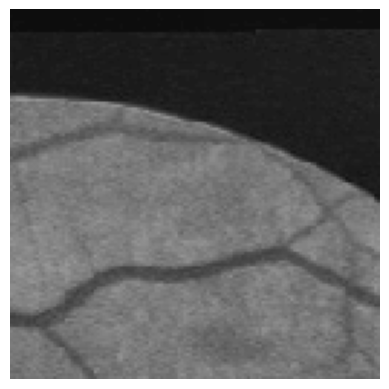

In [24]:
display_image(image[0, ...])

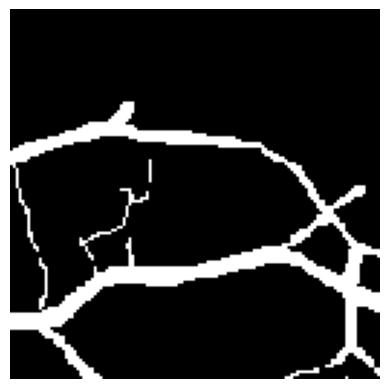

In [25]:
display_image(label[0, ...])

## Build and Compile

In [26]:
model = UNet(crop_wh, crop_wh, 1).build()

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

## Train

In [29]:
save_path = 'Unet_DRIVE.h5'
save_best_only = True

In [30]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 0s 332ms/step


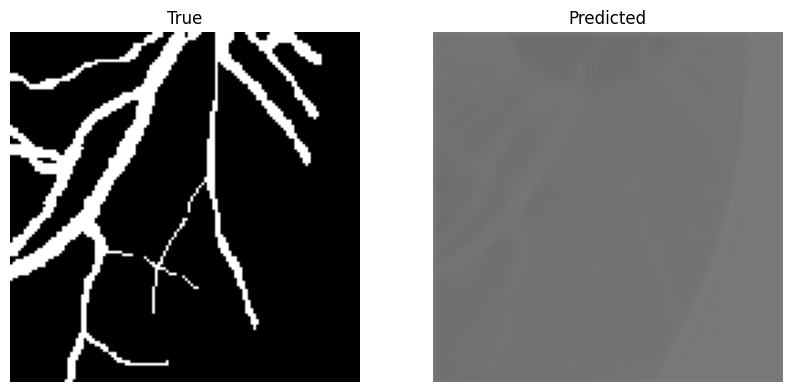


Jaccard: 0.09
Dice: 0.16


Epoch 1: val_loss improved from inf to 0.62393, saving model to Unet_DRIVE.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 44s - loss: 0.3870 - accuracy: 0.8829 - val_loss: 0.6239 - val_accuracy: 0.9188 - 44s/epoch - 5s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.62393 to 0.51238, saving model to Unet_DRIVE.h5
9/9 - 3s - loss: 0.2477 - accuracy: 0.9424 - val_loss: 0.5124 - val_accuracy: 0.8794 - 3s/epoch - 380ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.51238 to 0.39749, saving model to Unet_DRIVE.h5
9/9 - 3s - loss: 0.2106 - accuracy: 0.9475 - val_loss: 0.3975 - val_accuracy: 0.9129 - 3s/epoch - 378ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.39749 to 0.36511, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1862 - accuracy: 0.9521 - val_loss: 0.3651 - val_accuracy: 0.9188 - 4s/epoch - 445ms/step
Epoch 5/150

Epoch 5: val_loss did not improve from 0.36511
9/9 - 4s - loss: 0.1735 - accuracy: 0.9525 - val_loss: 0.3672 - val_accuracy: 0.9188 - 4s/epoch - 392ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.36511 to 0.34317, saving model to Unet_DRIVE.h5
9/9 - 4s - loss:

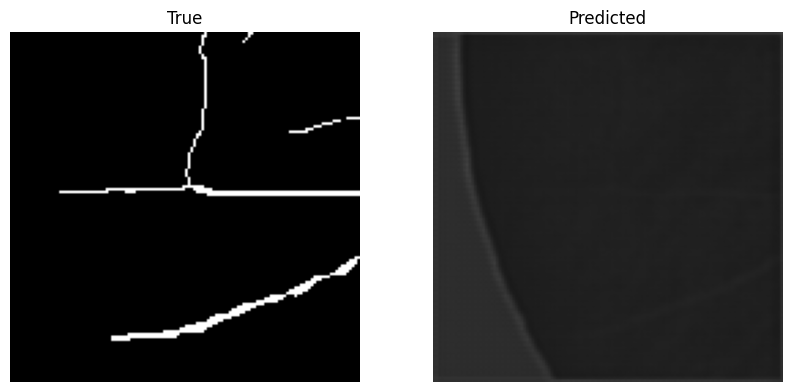


Jaccard: 0.06
Dice: 0.11


Epoch 10: val_loss improved from 0.31785 to 0.30605, saving model to Unet_DRIVE.h5
9/9 - 7s - loss: 0.1373 - accuracy: 0.9585 - val_loss: 0.3061 - val_accuracy: 0.9188 - 7s/epoch - 728ms/step
Epoch 11/150

Epoch 11: val_loss improved from 0.30605 to 0.29759, saving model to Unet_DRIVE.h5
9/9 - 3s - loss: 0.1335 - accuracy: 0.9585 - val_loss: 0.2976 - val_accuracy: 0.9188 - 3s/epoch - 381ms/step
Epoch 12/150

Epoch 12: val_loss improved from 0.29759 to 0.28934, saving model to Unet_DRIVE.h5
9/9 - 3s - loss: 0.1289 - accuracy: 0.9595 - val_loss: 0.2893 - val_accuracy: 0.9188 - 3s/epoch - 373ms/step
Epoch 13/150

Epoch 13: val_loss improved from 0.28934 to 0.28571, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1255 - accuracy: 0.9600 - val_loss: 0.2857 - val_accuracy: 0.9188 - 4s/epoch - 452ms/step
Epoch 14/150

Epoch 14: val_loss improved from 0.28571 to 0.27949, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1240 - accuracy: 0.9602 - val_loss: 0.2795 - v

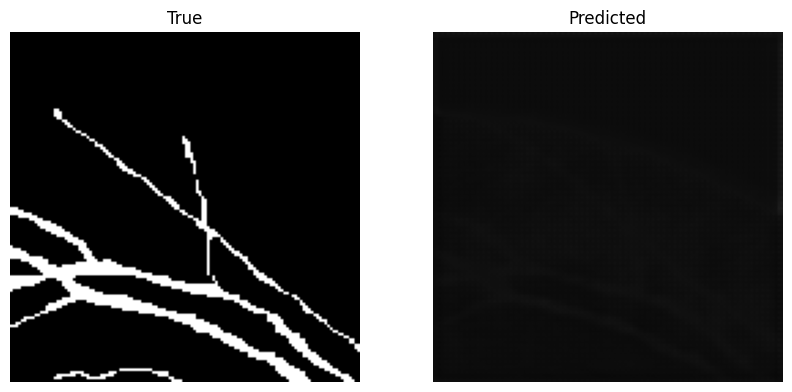


Jaccard: 0.04
Dice: 0.07


Epoch 19: val_loss did not improve from 0.27949
9/9 - 6s - loss: 0.1095 - accuracy: 0.9631 - val_loss: 0.2834 - val_accuracy: 0.9188 - 6s/epoch - 672ms/step
Epoch 20/150

Epoch 20: val_loss did not improve from 0.27949
9/9 - 3s - loss: 0.1086 - accuracy: 0.9629 - val_loss: 0.2910 - val_accuracy: 0.9188 - 3s/epoch - 349ms/step
Epoch 21/150

Epoch 21: val_loss did not improve from 0.27949
9/9 - 3s - loss: 0.1057 - accuracy: 0.9639 - val_loss: 0.2857 - val_accuracy: 0.9188 - 3s/epoch - 341ms/step
Epoch 22/150

Epoch 22: val_loss did not improve from 0.27949
9/9 - 4s - loss: 0.1036 - accuracy: 0.9642 - val_loss: 0.2808 - val_accuracy: 0.9188 - 4s/epoch - 423ms/step
Epoch 23/150

Epoch 23: val_loss did not improve from 0.27949
9/9 - 3s - loss: 0.1031 - accuracy: 0.9641 - val_loss: 0.2884 - val_accuracy: 0.9188 - 3s/epoch - 369ms/step
Epoch 24/150

Epoch 24: val_loss did not improve from 0.27949
9/9 - 3s - loss: 0.1013 - accuracy: 0.9646 - val_loss: 0.2887 - val_a

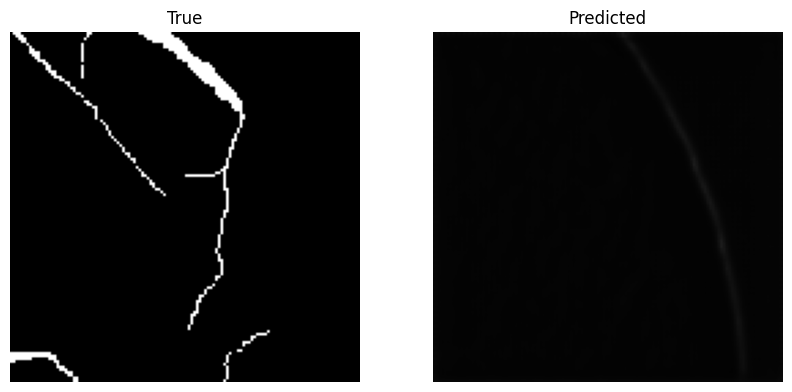


Jaccard: 0.03
Dice: 0.07


Epoch 28: val_loss did not improve from 0.27949
9/9 - 5s - loss: 0.0984 - accuracy: 0.9648 - val_loss: 0.3014 - val_accuracy: 0.9175 - 5s/epoch - 525ms/step
Epoch 29/150

Epoch 29: val_loss did not improve from 0.27949
9/9 - 4s - loss: 0.0967 - accuracy: 0.9655 - val_loss: 0.2811 - val_accuracy: 0.9182 - 4s/epoch - 413ms/step
Epoch 30/150

Epoch 30: val_loss improved from 0.27949 to 0.26170, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.0944 - accuracy: 0.9660 - val_loss: 0.2617 - val_accuracy: 0.9171 - 5s/epoch - 589ms/step
Epoch 31/150

Epoch 31: val_loss improved from 0.26170 to 0.23081, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.0945 - accuracy: 0.9660 - val_loss: 0.2308 - val_accuracy: 0.9151 - 5s/epoch - 584ms/step
Epoch 32/150

Epoch 32: val_loss improved from 0.23081 to 0.21717, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0941 - accuracy: 0.9660 - val_loss: 0.2172 - val_accuracy: 0.9208 - 4s/epoch - 423ms/step
Epoch 33/150

Epoch 33: va

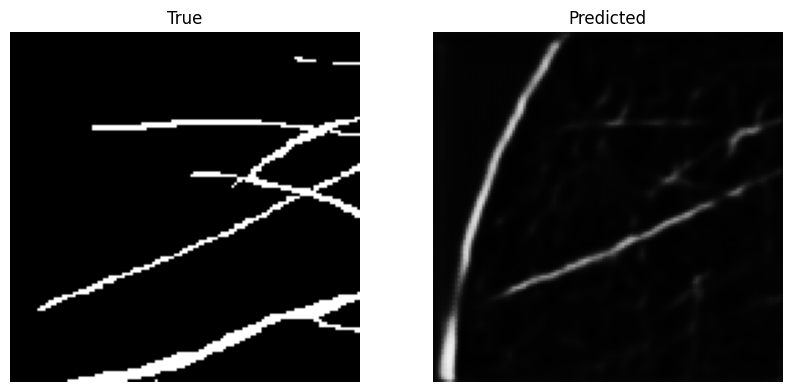


Jaccard: 0.13
Dice: 0.23


Epoch 37: val_loss did not improve from 0.21717
9/9 - 6s - loss: 0.0869 - accuracy: 0.9680 - val_loss: 0.2445 - val_accuracy: 0.9162 - 6s/epoch - 699ms/step
Epoch 38/150

Epoch 38: val_loss did not improve from 0.21717
9/9 - 4s - loss: 0.0862 - accuracy: 0.9682 - val_loss: 0.2326 - val_accuracy: 0.9191 - 4s/epoch - 397ms/step
Epoch 39/150

Epoch 39: val_loss did not improve from 0.21717
9/9 - 4s - loss: 0.0846 - accuracy: 0.9686 - val_loss: 0.2322 - val_accuracy: 0.9175 - 4s/epoch - 396ms/step
Epoch 40/150

Epoch 40: val_loss did not improve from 0.21717
9/9 - 5s - loss: 0.0830 - accuracy: 0.9693 - val_loss: 0.2196 - val_accuracy: 0.9180 - 5s/epoch - 546ms/step
Epoch 41/150

Epoch 41: val_loss improved from 0.21717 to 0.20160, saving model to Unet_DRIVE.h5
9/9 - 6s - loss: 0.0816 - accuracy: 0.9696 - val_loss: 0.2016 - val_accuracy: 0.9260 - 6s/epoch - 621ms/step
Epoch 42/150

Epoch 42: val_loss improved from 0.20160 to 0.19967, saving model to Unet_DRIVE.h5

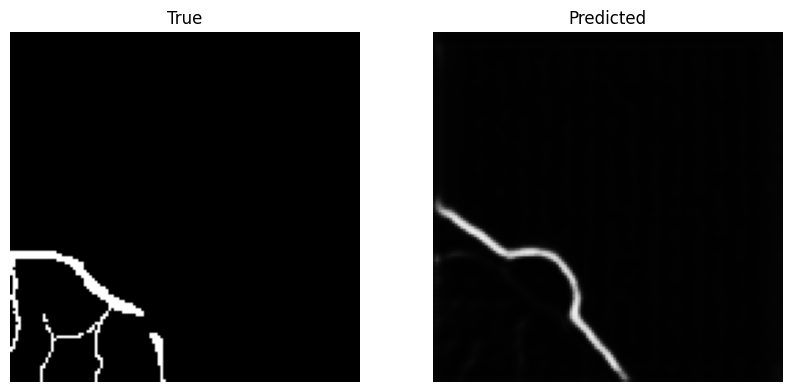


Jaccard: 0.22
Dice: 0.37


Epoch 46: val_loss improved from 0.19967 to 0.19168, saving model to Unet_DRIVE.h5
9/9 - 7s - loss: 0.0762 - accuracy: 0.9712 - val_loss: 0.1917 - val_accuracy: 0.9288 - 7s/epoch - 785ms/step
Epoch 47/150

Epoch 47: val_loss improved from 0.19168 to 0.18286, saving model to Unet_DRIVE.h5
9/9 - 3s - loss: 0.0760 - accuracy: 0.9711 - val_loss: 0.1829 - val_accuracy: 0.9327 - 3s/epoch - 370ms/step
Epoch 48/150

Epoch 48: val_loss did not improve from 0.18286
9/9 - 4s - loss: 0.0734 - accuracy: 0.9721 - val_loss: 0.1859 - val_accuracy: 0.9332 - 4s/epoch - 397ms/step
Epoch 49/150

Epoch 49: val_loss did not improve from 0.18286
9/9 - 4s - loss: 0.0731 - accuracy: 0.9720 - val_loss: 0.1832 - val_accuracy: 0.9332 - 4s/epoch - 463ms/step
Epoch 50/150

Epoch 50: val_loss improved from 0.18286 to 0.16078, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0739 - accuracy: 0.9717 - val_loss: 0.1608 - val_accuracy: 0.9387 - 4s/epoch - 445ms/step
Epoch 51/150

Epoch 51: va

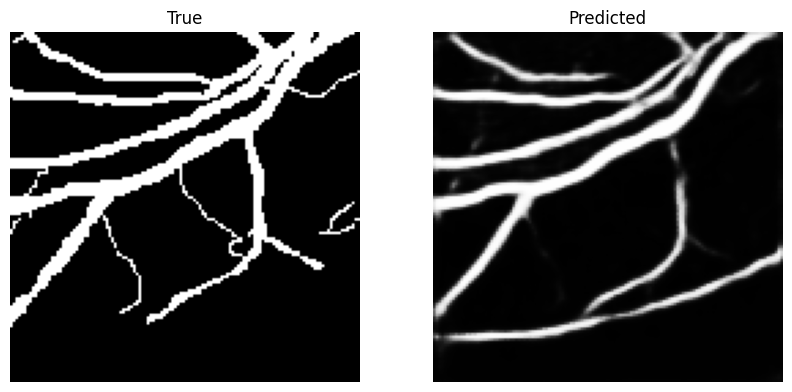


Jaccard: 0.47
Dice: 0.64


Epoch 55: val_loss improved from 0.12708 to 0.12423, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.0672 - accuracy: 0.9737 - val_loss: 0.1242 - val_accuracy: 0.9541 - 5s/epoch - 526ms/step
Epoch 56/150

Epoch 56: val_loss did not improve from 0.12423
9/9 - 4s - loss: 0.0651 - accuracy: 0.9744 - val_loss: 0.1387 - val_accuracy: 0.9517 - 4s/epoch - 439ms/step
Epoch 57/150

Epoch 57: val_loss improved from 0.12423 to 0.12160, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0623 - accuracy: 0.9754 - val_loss: 0.1216 - val_accuracy: 0.9576 - 4s/epoch - 430ms/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.12160
9/9 - 4s - loss: 0.0601 - accuracy: 0.9761 - val_loss: 0.1320 - val_accuracy: 0.9561 - 4s/epoch - 402ms/step
Epoch 59/150

Epoch 59: val_loss improved from 0.12160 to 0.11712, saving model to Unet_DRIVE.h5
9/9 - 6s - loss: 0.0583 - accuracy: 0.9769 - val_loss: 0.1171 - val_accuracy: 0.9600 - 6s/epoch - 651ms/step
Epoch 60/150

Epoch 60: va

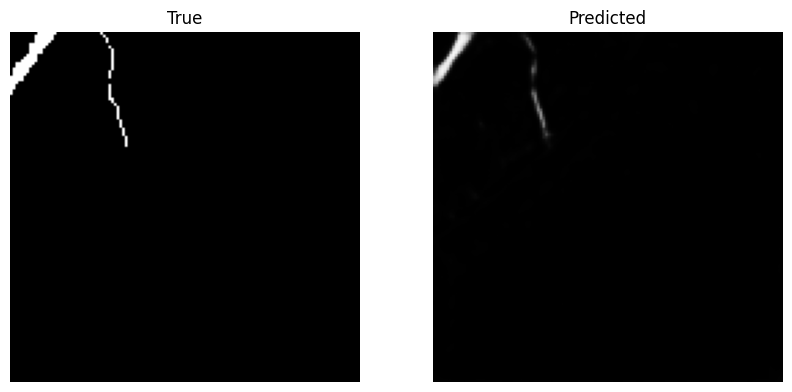


Jaccard: 0.52
Dice: 0.68


Epoch 64: val_loss did not improve from 0.10481
9/9 - 5s - loss: 0.0515 - accuracy: 0.9795 - val_loss: 0.1170 - val_accuracy: 0.9617 - 5s/epoch - 541ms/step
Epoch 65/150

Epoch 65: val_loss did not improve from 0.10481
9/9 - 4s - loss: 0.0509 - accuracy: 0.9797 - val_loss: 0.1102 - val_accuracy: 0.9637 - 4s/epoch - 432ms/step
Epoch 66/150

Epoch 66: val_loss did not improve from 0.10481
9/9 - 4s - loss: 0.0482 - accuracy: 0.9809 - val_loss: 0.1052 - val_accuracy: 0.9636 - 4s/epoch - 474ms/step
Epoch 67/150

Epoch 67: val_loss improved from 0.10481 to 0.10280, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0477 - accuracy: 0.9809 - val_loss: 0.1028 - val_accuracy: 0.9652 - 4s/epoch - 436ms/step
Epoch 68/150

Epoch 68: val_loss improved from 0.10280 to 0.10036, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0476 - accuracy: 0.9810 - val_loss: 0.1004 - val_accuracy: 0.9646 - 4s/epoch - 434ms/step
Epoch 69/150

Epoch 69: val_loss did not improve from 0.10036

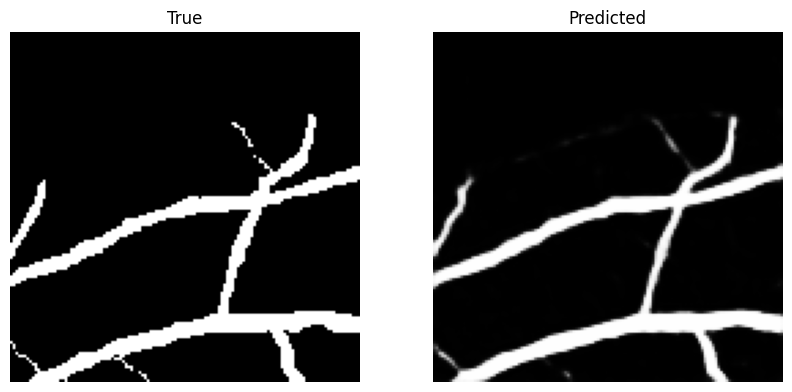


Jaccard: 0.60
Dice: 0.75


Epoch 73: val_loss did not improve from 0.10036
9/9 - 5s - loss: 0.0440 - accuracy: 0.9824 - val_loss: 0.1150 - val_accuracy: 0.9636 - 5s/epoch - 529ms/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0406 - accuracy: 0.9839 - val_loss: 0.1084 - val_accuracy: 0.9650 - 4s/epoch - 412ms/step
Epoch 75/150

Epoch 75: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0371 - accuracy: 0.9854 - val_loss: 0.1096 - val_accuracy: 0.9637 - 3s/epoch - 382ms/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0355 - accuracy: 0.9861 - val_loss: 0.1155 - val_accuracy: 0.9621 - 3s/epoch - 342ms/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0350 - accuracy: 0.9863 - val_loss: 0.1160 - val_accuracy: 0.9629 - 4s/epoch - 431ms/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0334 - accuracy: 0.9870 - val_loss: 0.1157 - val_a

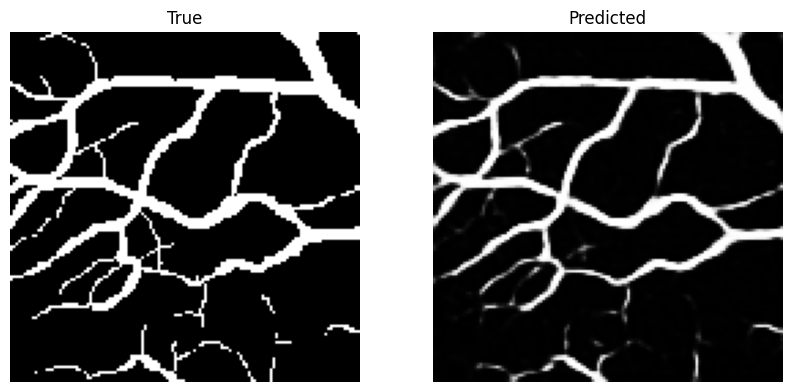


Jaccard: 0.71
Dice: 0.83


Epoch 82: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0298 - accuracy: 0.9885 - val_loss: 0.1119 - val_accuracy: 0.9659 - 4s/epoch - 464ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0298 - accuracy: 0.9884 - val_loss: 0.1201 - val_accuracy: 0.9627 - 3s/epoch - 348ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.10036
9/9 - 5s - loss: 0.0278 - accuracy: 0.9894 - val_loss: 0.1125 - val_accuracy: 0.9658 - 5s/epoch - 538ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0276 - accuracy: 0.9894 - val_loss: 0.1131 - val_accuracy: 0.9656 - 3s/epoch - 340ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0289 - accuracy: 0.9887 - val_loss: 0.1204 - val_accuracy: 0.9637 - 3s/epoch - 339ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.10036
9/9 - 5s - loss: 0.0266 - accuracy: 0.9898 - val_loss: 0.1219 - val_a

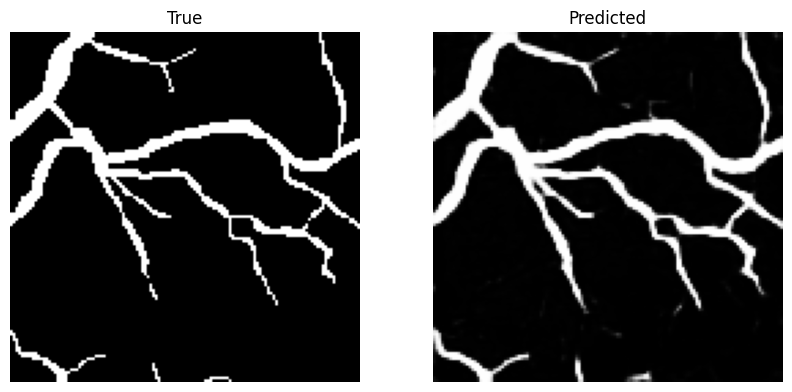


Jaccard: 0.78
Dice: 0.87


Epoch 91: val_loss did not improve from 0.10036
9/9 - 6s - loss: 0.0260 - accuracy: 0.9900 - val_loss: 0.1448 - val_accuracy: 0.9603 - 6s/epoch - 613ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0250 - accuracy: 0.9904 - val_loss: 0.1338 - val_accuracy: 0.9615 - 4s/epoch - 396ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0246 - accuracy: 0.9906 - val_loss: 0.1272 - val_accuracy: 0.9636 - 3s/epoch - 363ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0238 - accuracy: 0.9909 - val_loss: 0.1294 - val_accuracy: 0.9631 - 4s/epoch - 397ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.1318 - val_accuracy: 0.9619 - 3s/epoch - 333ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0211 - accuracy: 0.9921 - val_loss: 0.1307 - val_a

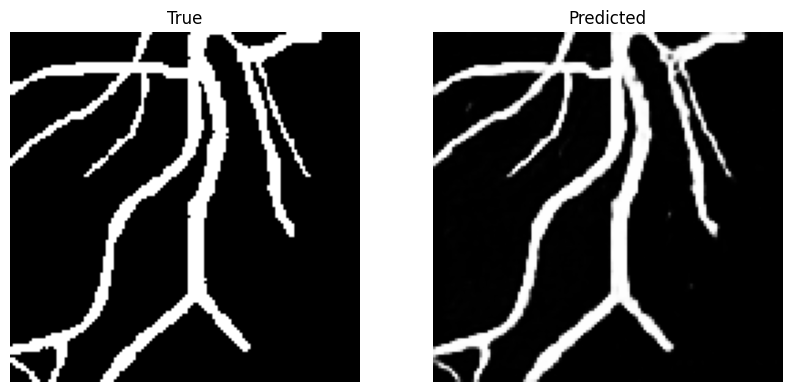


Jaccard: 0.77
Dice: 0.87


Epoch 100: val_loss did not improve from 0.10036
9/9 - 6s - loss: 0.0206 - accuracy: 0.9922 - val_loss: 0.1289 - val_accuracy: 0.9652 - 6s/epoch - 636ms/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.1297 - val_accuracy: 0.9650 - 4s/epoch - 394ms/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0182 - accuracy: 0.9933 - val_loss: 0.1289 - val_accuracy: 0.9652 - 4s/epoch - 407ms/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0165 - accuracy: 0.9941 - val_loss: 0.1289 - val_accuracy: 0.9650 - 4s/epoch - 471ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.1343 - val_accuracy: 0.9638 - 4s/epoch - 395ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.1

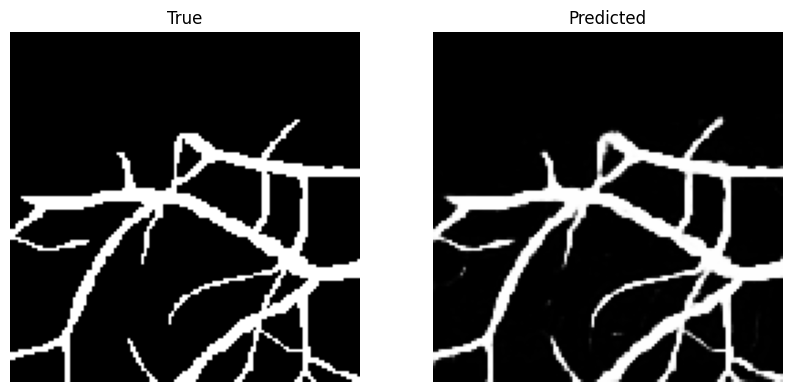


Jaccard: 0.86
Dice: 0.93


Epoch 109: val_loss did not improve from 0.10036
9/9 - 7s - loss: 0.0151 - accuracy: 0.9946 - val_loss: 0.1435 - val_accuracy: 0.9625 - 7s/epoch - 796ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0145 - accuracy: 0.9948 - val_loss: 0.1434 - val_accuracy: 0.9641 - 4s/epoch - 395ms/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0137 - accuracy: 0.9952 - val_loss: 0.1565 - val_accuracy: 0.9602 - 4s/epoch - 401ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.1450 - val_accuracy: 0.9635 - 4s/epoch - 435ms/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0125 - accuracy: 0.9957 - val_loss: 0.1397 - val_accuracy: 0.9649 - 4s/epoch - 457ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.1

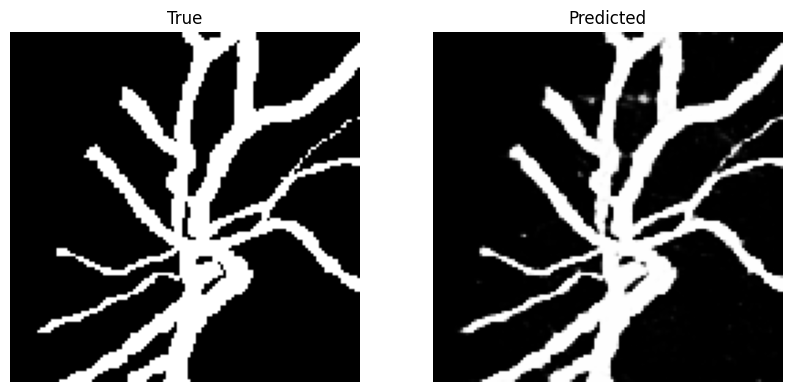


Jaccard: 0.88
Dice: 0.94


Epoch 118: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.1538 - val_accuracy: 0.9618 - 4s/epoch - 476ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.1474 - val_accuracy: 0.9641 - 4s/epoch - 460ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.1477 - val_accuracy: 0.9647 - 3s/epoch - 347ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.1454 - val_accuracy: 0.9649 - 4s/epoch - 394ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.1614 - val_accuracy: 0.9606 - 4s/epoch - 472ms/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.1

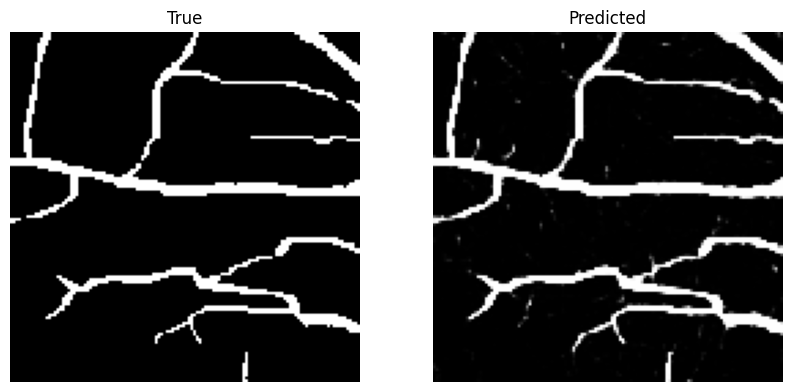


Jaccard: 0.86
Dice: 0.93


Epoch 127: val_loss did not improve from 0.10036
9/9 - 7s - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.1721 - val_accuracy: 0.9585 - 7s/epoch - 822ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.1561 - val_accuracy: 0.9643 - 4s/epoch - 394ms/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.1579 - val_accuracy: 0.9630 - 4s/epoch - 421ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.1616 - val_accuracy: 0.9638 - 4s/epoch - 467ms/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.1589 - val_accuracy: 0.9639 - 3s/epoch - 348ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.1

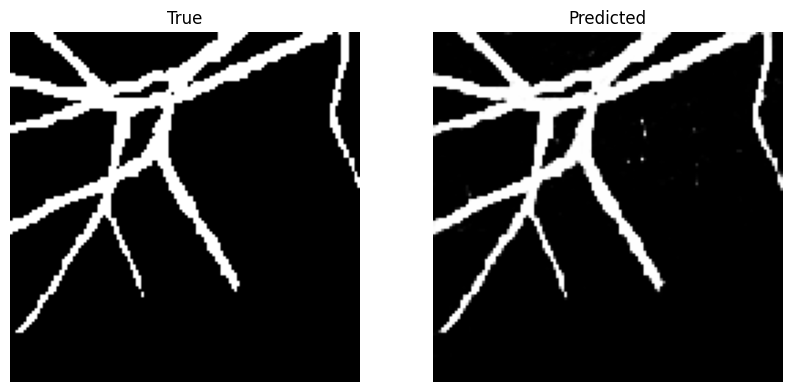


Jaccard: 0.92
Dice: 0.96


Epoch 136: val_loss did not improve from 0.10036
9/9 - 6s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.1759 - val_accuracy: 0.9621 - 6s/epoch - 686ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.1695 - val_accuracy: 0.9649 - 3s/epoch - 341ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.1839 - val_accuracy: 0.9605 - 4s/epoch - 400ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.1853 - val_accuracy: 0.9612 - 4s/epoch - 418ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.1789 - val_accuracy: 0.9624 - 4s/epoch - 394ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.1

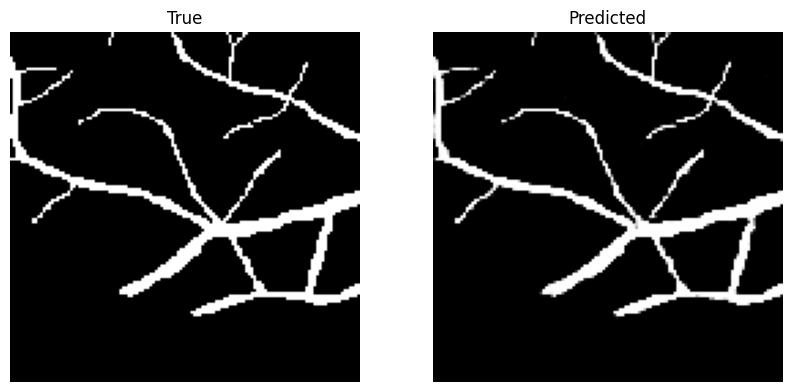


Jaccard: 0.93
Dice: 0.96


Epoch 145: val_loss did not improve from 0.10036
9/9 - 5s - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.1807 - val_accuracy: 0.9651 - 5s/epoch - 595ms/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.1811 - val_accuracy: 0.9640 - 3s/epoch - 340ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.1824 - val_accuracy: 0.9648 - 3s/epoch - 334ms/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.10036
9/9 - 5s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.1837 - val_accuracy: 0.9651 - 5s/epoch - 559ms/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.10036
9/9 - 3s - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.1820 - val_accuracy: 0.9639 - 3s/epoch - 348ms/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.10036
9/9 - 4s - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.1

In [31]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

## Evaluate and Plot Results

In [32]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='grayscale',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 1 channel image. (grayscale)


In [33]:
test = test_data.get_dataset()

In [34]:
_ = model.evaluate(test)

20/20 [==============================] - 2s 52ms/step - loss: 0.0310 - accuracy: 0.9932


In [35]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

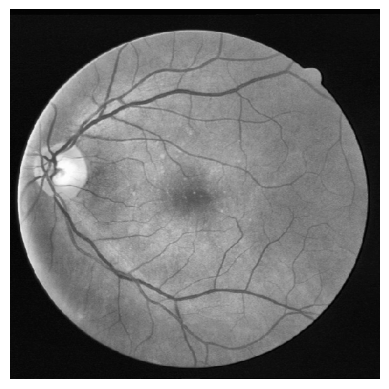

In [36]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 0s 475ms/step


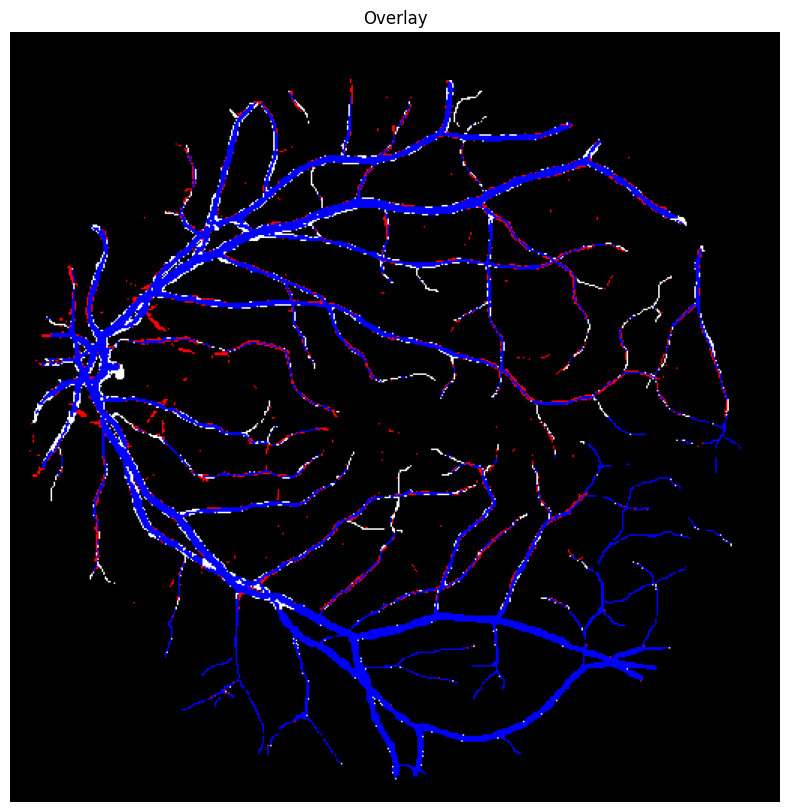

In [37]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))

# MobilineNetV2 - Transfer Learning

## Preprocess and Display Images

In [38]:
data = DatasetPreprocess(image_paths, label_paths, output_type='color',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 3 channel image.


In [39]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

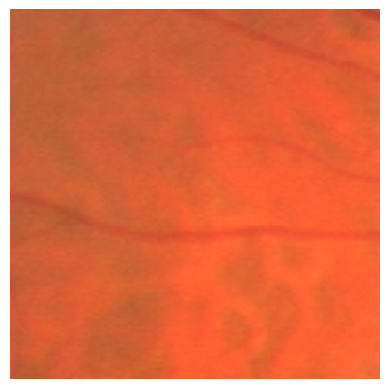

In [40]:
display_image(image[0, ...])

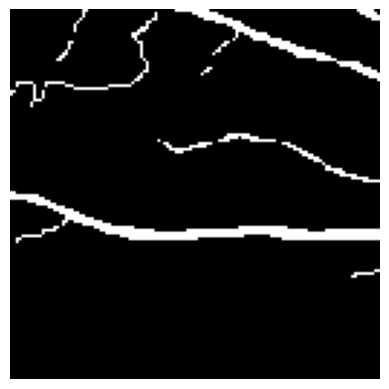

In [41]:
display_image(label[0, ...])

## Build and Compile

In [42]:
model = MV2Transfer(crop_wh, crop_wh, 1).build()

In [43]:
model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 64, 64, 96),         1841984   ['input_3[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

## Train

In [45]:
save_path = 'MV2net_transfer_DRIVE.h5'
save_best_only = True

In [46]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 1s 842ms/step


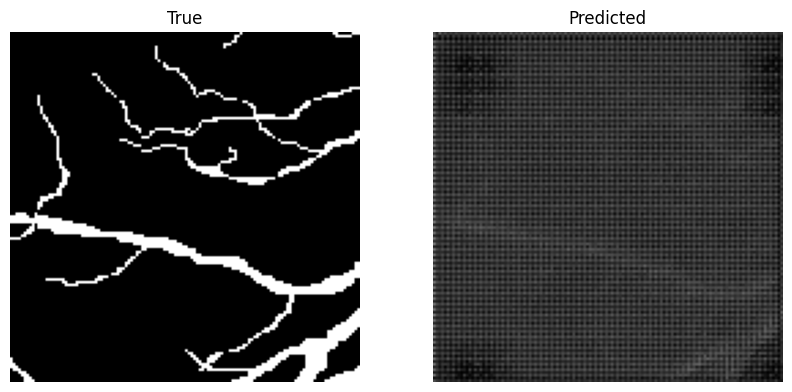


Jaccard: 0.08
Dice: 0.15


Epoch 1: val_loss improved from inf to 0.61415, saving model to MV2net_transfer_DRIVE.h5
9/9 - 17s - loss: 1.0353 - accuracy: 0.5493 - val_loss: 0.6142 - val_accuracy: 0.9187 - 17s/epoch - 2s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.61415 to 0.54470, saving model to MV2net_transfer_DRIVE.h5
9/9 - 6s - loss: 0.5715 - accuracy: 0.9128 - val_loss: 0.5447 - val_accuracy: 0.9188 - 6s/epoch - 680ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.54470 to 0.51842, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.5269 - accuracy: 0.9129 - val_loss: 0.5184 - val_accuracy: 0.9188 - 3s/epoch - 311ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.51842 to 0.48557, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.4853 - accuracy: 0.9150 - val_loss: 0.4856 - val_accuracy: 0.9188 - 3s/epoch - 309ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.48557 to 0.46357, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.4368 

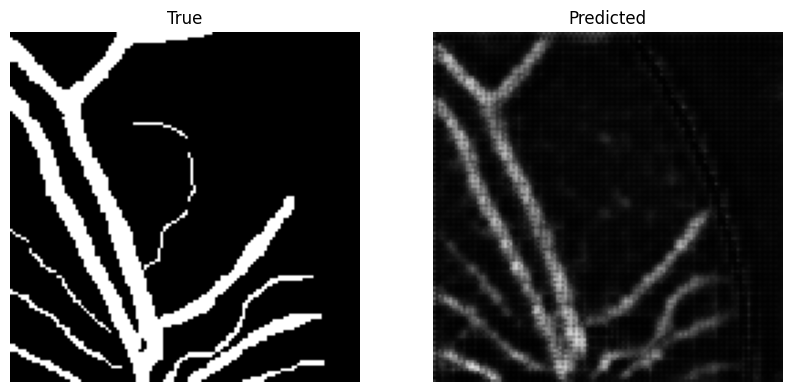


Jaccard: 0.20
Dice: 0.33


Epoch 10: val_loss improved from 0.40802 to 0.40055, saving model to MV2net_transfer_DRIVE.h5
9/9 - 7s - loss: 0.3200 - accuracy: 0.9520 - val_loss: 0.4005 - val_accuracy: 0.9303 - 7s/epoch - 728ms/step
Epoch 11/150

Epoch 11: val_loss improved from 0.40055 to 0.37690, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.3068 - accuracy: 0.9539 - val_loss: 0.3769 - val_accuracy: 0.9384 - 3s/epoch - 360ms/step
Epoch 12/150

Epoch 12: val_loss did not improve from 0.37690
9/9 - 3s - loss: 0.2992 - accuracy: 0.9544 - val_loss: 0.3779 - val_accuracy: 0.9366 - 3s/epoch - 299ms/step
Epoch 13/150

Epoch 13: val_loss improved from 0.37690 to 0.37530, saving model to MV2net_transfer_DRIVE.h5
9/9 - 5s - loss: 0.2917 - accuracy: 0.9553 - val_loss: 0.3753 - val_accuracy: 0.9371 - 5s/epoch - 504ms/step
Epoch 14/150

Epoch 14: val_loss did not improve from 0.37530
9/9 - 3s - loss: 0.2861 - accuracy: 0.9558 - val_loss: 0.3793 - val_accuracy: 0.9359 - 3s/epoch - 307m

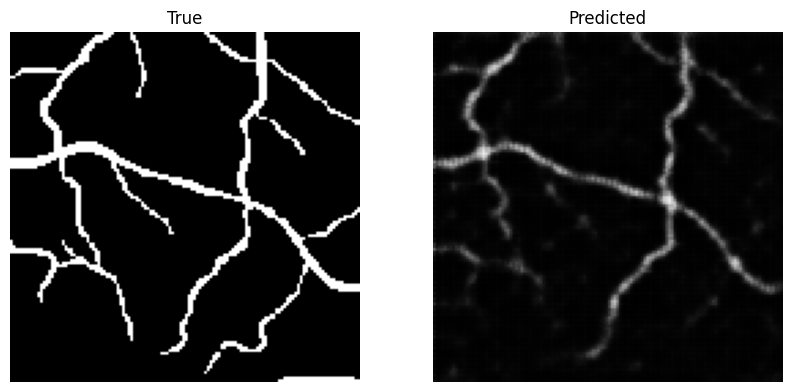


Jaccard: 0.27
Dice: 0.42


Epoch 19: val_loss improved from 0.36040 to 0.35189, saving model to MV2net_transfer_DRIVE.h5
9/9 - 7s - loss: 0.2607 - accuracy: 0.9598 - val_loss: 0.3519 - val_accuracy: 0.9430 - 7s/epoch - 727ms/step
Epoch 20/150

Epoch 20: val_loss improved from 0.35189 to 0.33551, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2572 - accuracy: 0.9603 - val_loss: 0.3355 - val_accuracy: 0.9472 - 3s/epoch - 368ms/step
Epoch 21/150

Epoch 21: val_loss improved from 0.33551 to 0.32914, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2510 - accuracy: 0.9612 - val_loss: 0.3291 - val_accuracy: 0.9489 - 3s/epoch - 378ms/step
Epoch 22/150

Epoch 22: val_loss did not improve from 0.32914
9/9 - 4s - loss: 0.2511 - accuracy: 0.9613 - val_loss: 0.3367 - val_accuracy: 0.9470 - 4s/epoch - 459ms/step
Epoch 23/150

Epoch 23: val_loss improved from 0.32914 to 0.32311, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2471 - accuracy: 0.9619 - val_loss: 0

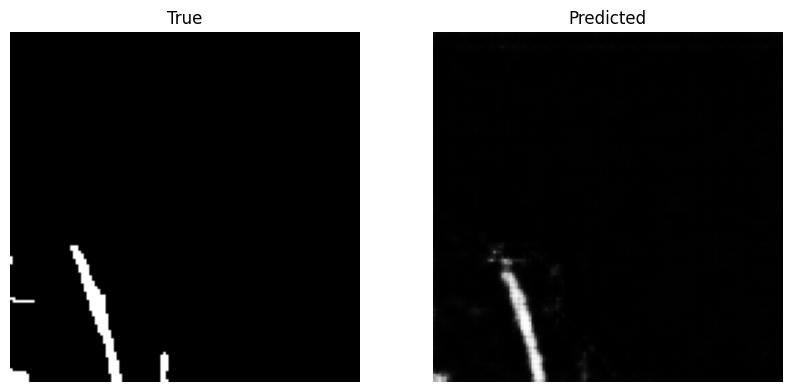


Jaccard: 0.48
Dice: 0.65


Epoch 28: val_loss improved from 0.28416 to 0.27934, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2327 - accuracy: 0.9646 - val_loss: 0.2793 - val_accuracy: 0.9582 - 4s/epoch - 422ms/step
Epoch 29/150

Epoch 29: val_loss did not improve from 0.27934
9/9 - 2s - loss: 0.2271 - accuracy: 0.9656 - val_loss: 0.2843 - val_accuracy: 0.9576 - 2s/epoch - 242ms/step
Epoch 30/150

Epoch 30: val_loss improved from 0.27934 to 0.27725, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2214 - accuracy: 0.9665 - val_loss: 0.2773 - val_accuracy: 0.9585 - 3s/epoch - 365ms/step
Epoch 31/150

Epoch 31: val_loss improved from 0.27725 to 0.27480, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2160 - accuracy: 0.9673 - val_loss: 0.2748 - val_accuracy: 0.9586 - 4s/epoch - 450ms/step
Epoch 32/150

Epoch 32: val_loss did not improve from 0.27480
9/9 - 2s - loss: 0.2135 - accuracy: 0.9677 - val_loss: 0.2800 - val_accuracy: 0.9579 - 2s/epoch - 243m

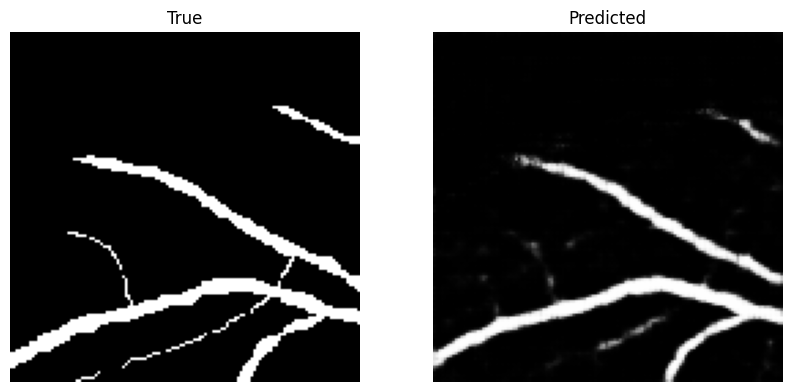


Jaccard: 0.61
Dice: 0.76


Epoch 37: val_loss did not improve from 0.26436
9/9 - 4s - loss: 0.1986 - accuracy: 0.9705 - val_loss: 0.2694 - val_accuracy: 0.9582 - 4s/epoch - 486ms/step
Epoch 38/150

Epoch 38: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1930 - accuracy: 0.9712 - val_loss: 0.2687 - val_accuracy: 0.9584 - 2s/epoch - 253ms/step
Epoch 39/150

Epoch 39: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1878 - accuracy: 0.9720 - val_loss: 0.2702 - val_accuracy: 0.9585 - 2s/epoch - 245ms/step
Epoch 40/150

Epoch 40: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1852 - accuracy: 0.9726 - val_loss: 0.2678 - val_accuracy: 0.9576 - 2s/epoch - 229ms/step
Epoch 41/150

Epoch 41: val_loss did not improve from 0.26436
9/9 - 5s - loss: 0.1830 - accuracy: 0.9730 - val_loss: 0.2733 - val_accuracy: 0.9574 - 5s/epoch - 515ms/step
Epoch 42/150

Epoch 42: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1825 - accuracy: 0.9732 - val_loss: 0.2726 - val_a

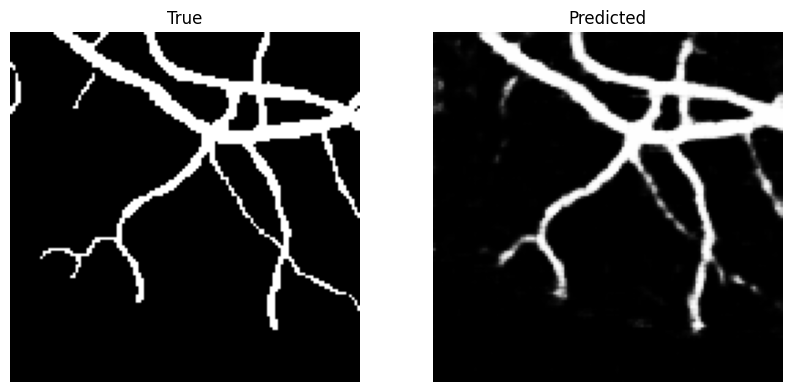


Jaccard: 0.63
Dice: 0.77


Epoch 46: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1668 - accuracy: 0.9760 - val_loss: 0.2831 - val_accuracy: 0.9553 - 3s/epoch - 374ms/step
Epoch 47/150

Epoch 47: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1655 - accuracy: 0.9758 - val_loss: 0.2793 - val_accuracy: 0.9565 - 3s/epoch - 296ms/step
Epoch 48/150

Epoch 48: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1587 - accuracy: 0.9771 - val_loss: 0.2844 - val_accuracy: 0.9553 - 3s/epoch - 310ms/step
Epoch 49/150

Epoch 49: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1565 - accuracy: 0.9773 - val_loss: 0.2852 - val_accuracy: 0.9570 - 3s/epoch - 366ms/step
Epoch 50/150

Epoch 50: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1524 - accuracy: 0.9780 - val_loss: 0.2833 - val_accuracy: 0.9562 - 2s/epoch - 233ms/step
Epoch 51/150

Epoch 51: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1483 - accuracy: 0.9789 - val_loss: 0.2884 - val_a

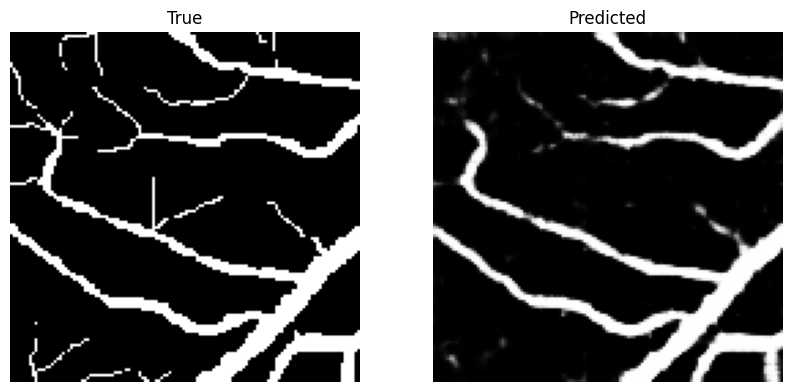


Jaccard: 0.72
Dice: 0.83


Epoch 55: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1386 - accuracy: 0.9804 - val_loss: 0.2975 - val_accuracy: 0.9556 - 3s/epoch - 349ms/step
Epoch 56/150

Epoch 56: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1370 - accuracy: 0.9806 - val_loss: 0.3029 - val_accuracy: 0.9562 - 2s/epoch - 228ms/step
Epoch 57/150

Epoch 57: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1349 - accuracy: 0.9808 - val_loss: 0.3051 - val_accuracy: 0.9563 - 2s/epoch - 222ms/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1328 - accuracy: 0.9812 - val_loss: 0.3025 - val_accuracy: 0.9557 - 3s/epoch - 337ms/step
Epoch 59/150

Epoch 59: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1290 - accuracy: 0.9819 - val_loss: 0.3058 - val_accuracy: 0.9546 - 3s/epoch - 317ms/step
Epoch 60/150

Epoch 60: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1255 - accuracy: 0.9824 - val_loss: 0.3081 - val_a

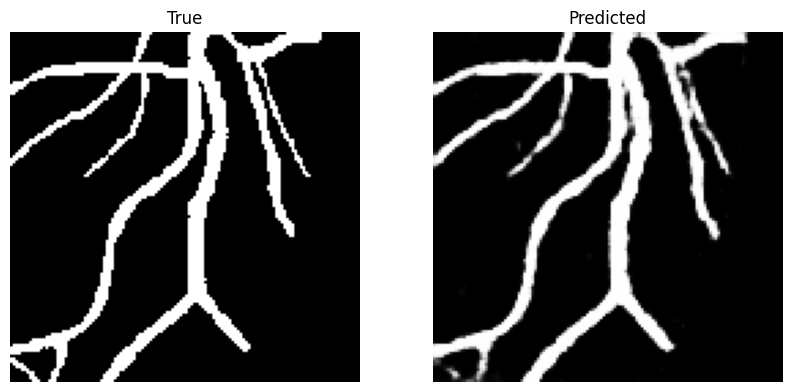


Jaccard: 0.78
Dice: 0.88


Epoch 64: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1228 - accuracy: 0.9828 - val_loss: 0.3173 - val_accuracy: 0.9549 - 3s/epoch - 344ms/step
Epoch 65/150

Epoch 65: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1213 - accuracy: 0.9829 - val_loss: 0.3227 - val_accuracy: 0.9546 - 2s/epoch - 231ms/step
Epoch 66/150

Epoch 66: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1168 - accuracy: 0.9838 - val_loss: 0.3206 - val_accuracy: 0.9535 - 2s/epoch - 228ms/step
Epoch 67/150

Epoch 67: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1128 - accuracy: 0.9844 - val_loss: 0.3239 - val_accuracy: 0.9547 - 3s/epoch - 286ms/step
Epoch 68/150

Epoch 68: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1087 - accuracy: 0.9849 - val_loss: 0.3267 - val_accuracy: 0.9551 - 3s/epoch - 374ms/step
Epoch 69/150

Epoch 69: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1078 - accuracy: 0.9850 - val_loss: 0.3306 - val_a

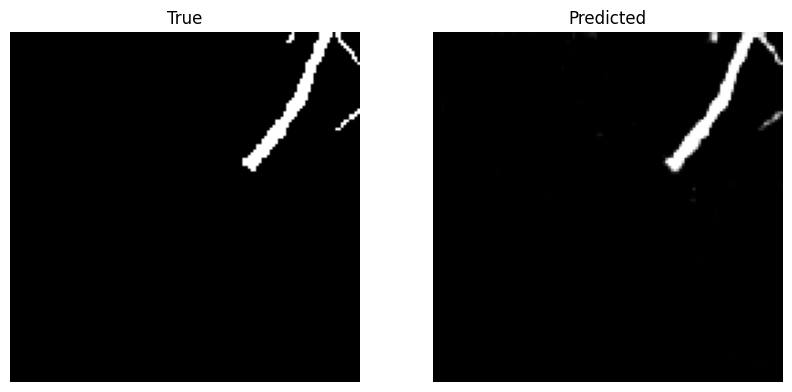


Jaccard: 0.79
Dice: 0.88


Epoch 73: val_loss did not improve from 0.26436
9/9 - 5s - loss: 0.1018 - accuracy: 0.9859 - val_loss: 0.3355 - val_accuracy: 0.9544 - 5s/epoch - 516ms/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1003 - accuracy: 0.9862 - val_loss: 0.3443 - val_accuracy: 0.9550 - 3s/epoch - 355ms/step
Epoch 75/150

Epoch 75: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.1025 - accuracy: 0.9856 - val_loss: 0.3423 - val_accuracy: 0.9544 - 3s/epoch - 295ms/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.1019 - accuracy: 0.9859 - val_loss: 0.3421 - val_accuracy: 0.9534 - 2s/epoch - 227ms/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0989 - accuracy: 0.9864 - val_loss: 0.3449 - val_accuracy: 0.9541 - 3s/epoch - 291ms/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0957 - accuracy: 0.9868 - val_loss: 0.3485 - val_a

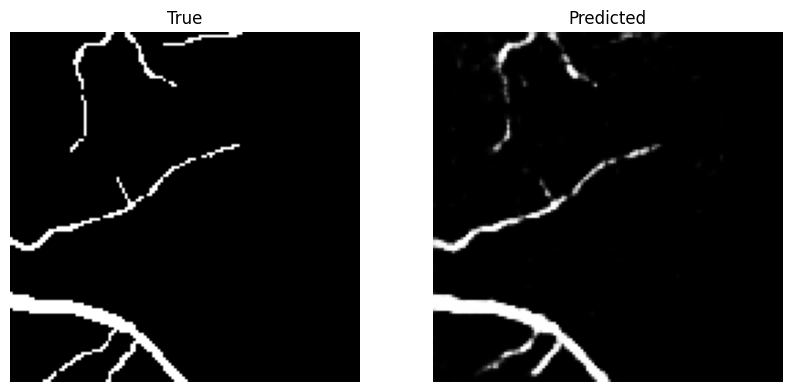


Jaccard: 0.83
Dice: 0.91


Epoch 82: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0886 - accuracy: 0.9881 - val_loss: 0.3545 - val_accuracy: 0.9537 - 3s/epoch - 369ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0893 - accuracy: 0.9877 - val_loss: 0.3544 - val_accuracy: 0.9527 - 2s/epoch - 244ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0888 - accuracy: 0.9879 - val_loss: 0.3585 - val_accuracy: 0.9524 - 2s/epoch - 231ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0882 - accuracy: 0.9881 - val_loss: 0.3627 - val_accuracy: 0.9522 - 3s/epoch - 310ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0874 - accuracy: 0.9880 - val_loss: 0.3625 - val_accuracy: 0.9520 - 2s/epoch - 236ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0846 - accuracy: 0.9888 - val_loss: 0.3662 - val_a

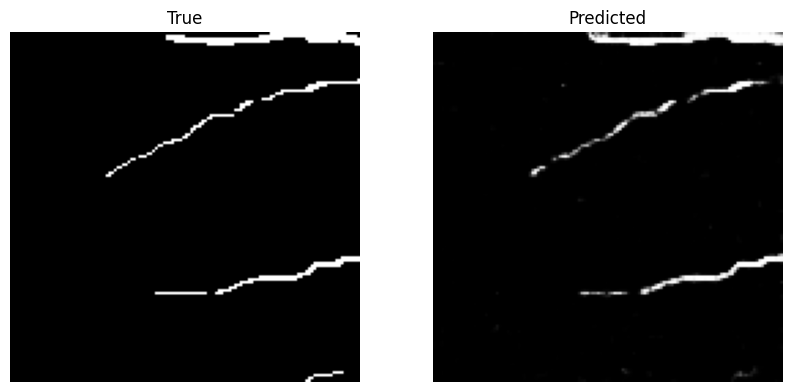


Jaccard: 0.83
Dice: 0.90


Epoch 91: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0754 - accuracy: 0.9900 - val_loss: 0.3745 - val_accuracy: 0.9533 - 3s/epoch - 347ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0745 - accuracy: 0.9901 - val_loss: 0.3710 - val_accuracy: 0.9522 - 2s/epoch - 253ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0767 - accuracy: 0.9897 - val_loss: 0.3780 - val_accuracy: 0.9533 - 3s/epoch - 371ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0730 - accuracy: 0.9904 - val_loss: 0.3834 - val_accuracy: 0.9523 - 3s/epoch - 297ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0738 - accuracy: 0.9900 - val_loss: 0.3841 - val_accuracy: 0.9532 - 2s/epoch - 232ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0711 - accuracy: 0.9906 - val_loss: 0.3869 - val_a

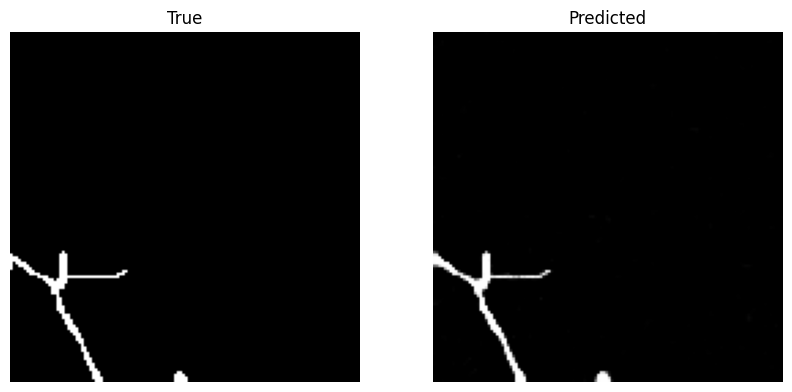


Jaccard: 0.87
Dice: 0.93


Epoch 100: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0682 - accuracy: 0.9910 - val_loss: 0.3853 - val_accuracy: 0.9520 - 3s/epoch - 364ms/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0671 - accuracy: 0.9913 - val_loss: 0.3880 - val_accuracy: 0.9510 - 3s/epoch - 298ms/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0653 - accuracy: 0.9915 - val_loss: 0.3924 - val_accuracy: 0.9521 - 2s/epoch - 232ms/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0657 - accuracy: 0.9914 - val_loss: 0.3908 - val_accuracy: 0.9513 - 3s/epoch - 298ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0662 - accuracy: 0.9913 - val_loss: 0.3946 - val_accuracy: 0.9515 - 3s/epoch - 295ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0610 - accuracy: 0.9922 - val_loss: 0.3

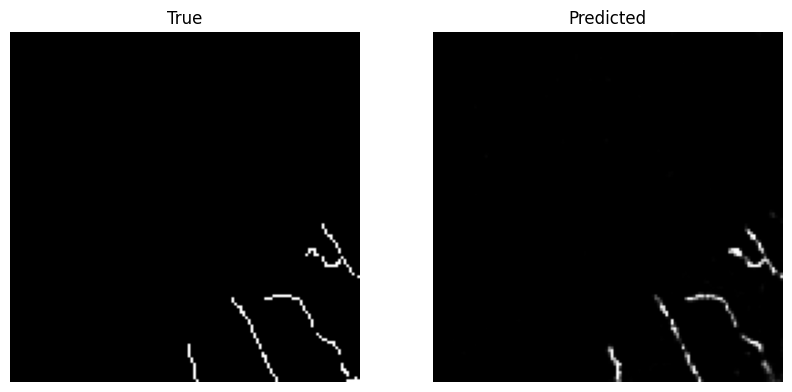


Jaccard: 0.89
Dice: 0.94


Epoch 109: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0562 - accuracy: 0.9930 - val_loss: 0.4025 - val_accuracy: 0.9522 - 3s/epoch - 372ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0542 - accuracy: 0.9933 - val_loss: 0.3989 - val_accuracy: 0.9522 - 3s/epoch - 295ms/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0556 - accuracy: 0.9932 - val_loss: 0.4076 - val_accuracy: 0.9513 - 2s/epoch - 226ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0534 - accuracy: 0.9935 - val_loss: 0.4167 - val_accuracy: 0.9523 - 3s/epoch - 295ms/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0547 - accuracy: 0.9932 - val_loss: 0.4107 - val_accuracy: 0.9517 - 3s/epoch - 299ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0532 - accuracy: 0.9934 - val_loss: 0.4

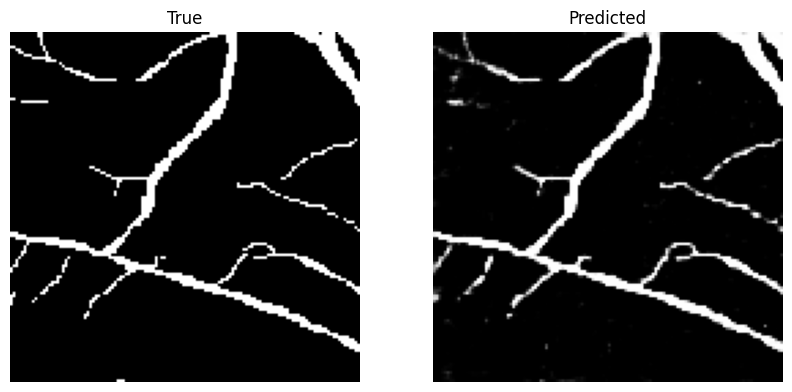


Jaccard: 0.88
Dice: 0.94


Epoch 118: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0504 - accuracy: 0.9938 - val_loss: 0.4204 - val_accuracy: 0.9504 - 3s/epoch - 346ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0486 - accuracy: 0.9941 - val_loss: 0.4198 - val_accuracy: 0.9508 - 2s/epoch - 225ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0516 - accuracy: 0.9938 - val_loss: 0.4267 - val_accuracy: 0.9508 - 3s/epoch - 374ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0480 - accuracy: 0.9942 - val_loss: 0.4287 - val_accuracy: 0.9512 - 2s/epoch - 228ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0481 - accuracy: 0.9941 - val_loss: 0.4301 - val_accuracy: 0.9514 - 3s/epoch - 289ms/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0473 - accuracy: 0.9941 - val_loss: 0.4

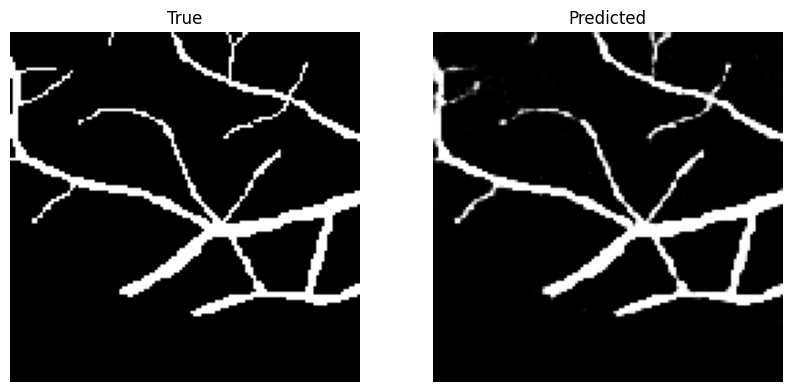


Jaccard: 0.92
Dice: 0.96


Epoch 127: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0455 - accuracy: 0.9945 - val_loss: 0.4417 - val_accuracy: 0.9523 - 3s/epoch - 376ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0430 - accuracy: 0.9950 - val_loss: 0.4444 - val_accuracy: 0.9512 - 3s/epoch - 301ms/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0437 - accuracy: 0.9947 - val_loss: 0.4454 - val_accuracy: 0.9515 - 3s/epoch - 363ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0435 - accuracy: 0.9947 - val_loss: 0.4440 - val_accuracy: 0.9503 - 2s/epoch - 232ms/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0427 - accuracy: 0.9948 - val_loss: 0.4475 - val_accuracy: 0.9510 - 3s/epoch - 295ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0443 - accuracy: 0.9946 - val_loss: 0.4

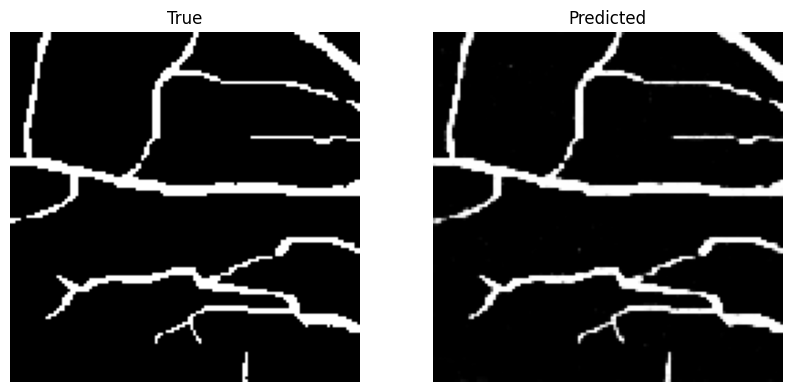


Jaccard: 0.92
Dice: 0.96


Epoch 136: val_loss did not improve from 0.26436
9/9 - 4s - loss: 0.0387 - accuracy: 0.9955 - val_loss: 0.4517 - val_accuracy: 0.9515 - 4s/epoch - 436ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0379 - accuracy: 0.9956 - val_loss: 0.4568 - val_accuracy: 0.9516 - 3s/epoch - 353ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0361 - accuracy: 0.9959 - val_loss: 0.4564 - val_accuracy: 0.9512 - 3s/epoch - 296ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0354 - accuracy: 0.9960 - val_loss: 0.4538 - val_accuracy: 0.9513 - 3s/epoch - 299ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0332 - accuracy: 0.9964 - val_loss: 0.4572 - val_accuracy: 0.9505 - 3s/epoch - 309ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0322 - accuracy: 0.9965 - val_loss: 0.4

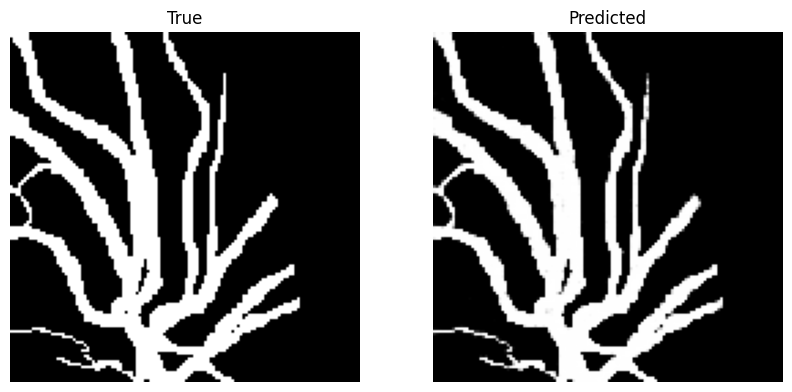


Jaccard: 0.95
Dice: 0.97


Epoch 145: val_loss did not improve from 0.26436
9/9 - 4s - loss: 0.0329 - accuracy: 0.9964 - val_loss: 0.4702 - val_accuracy: 0.9521 - 4s/epoch - 470ms/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0336 - accuracy: 0.9962 - val_loss: 0.4696 - val_accuracy: 0.9514 - 2s/epoch - 232ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0310 - accuracy: 0.9966 - val_loss: 0.4713 - val_accuracy: 0.9511 - 2s/epoch - 220ms/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.26436
9/9 - 3s - loss: 0.0311 - accuracy: 0.9966 - val_loss: 0.4686 - val_accuracy: 0.9500 - 3s/epoch - 297ms/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0324 - accuracy: 0.9963 - val_loss: 0.4783 - val_accuracy: 0.9509 - 2s/epoch - 231ms/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.26436
9/9 - 2s - loss: 0.0325 - accuracy: 0.9963 - val_loss: 0.4

In [47]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

## Evaluate and Plot Results

In [48]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='color',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 3 channel image.


In [49]:
test = test_data.get_dataset()

In [50]:
_ = model.evaluate(test)

20/20 [==============================] - 2s 35ms/step - loss: 0.0936 - accuracy: 0.9904


In [51]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

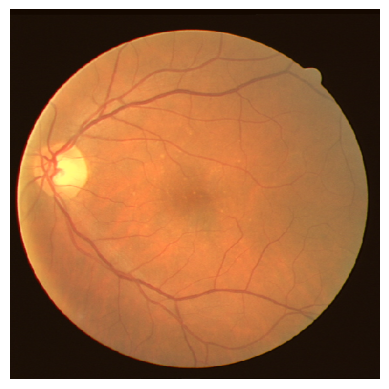

In [52]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 1s 862ms/step


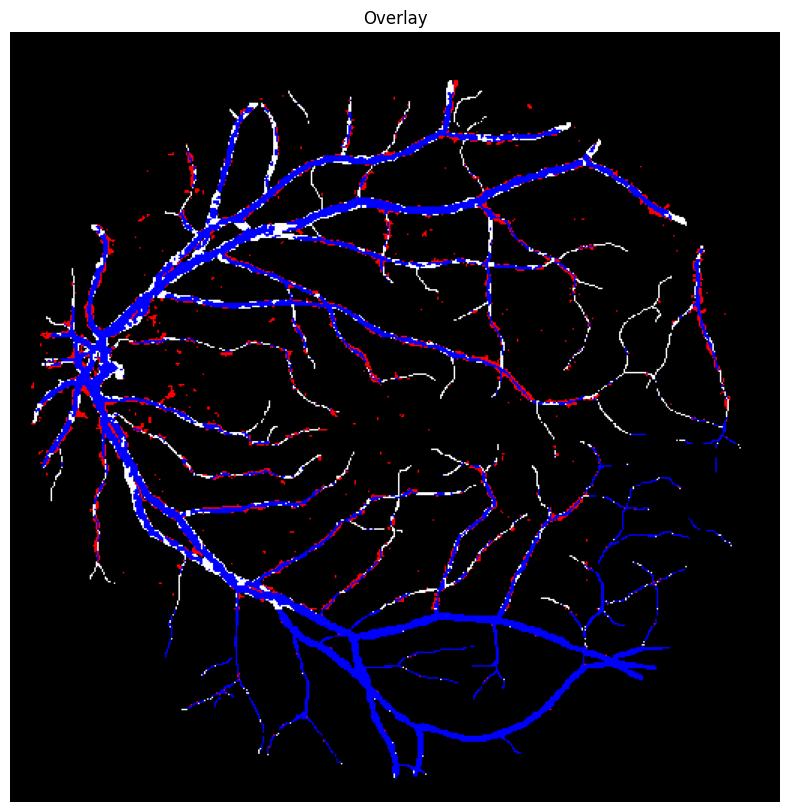

In [53]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))

# MobileNetV2

## Preprocess and Display Images

In [54]:
data = DatasetPreprocess(image_paths, label_paths, output_type='color',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 3 channel image.


In [55]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

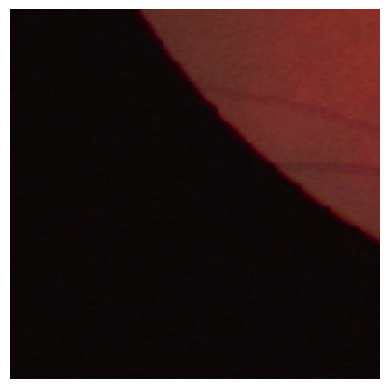

In [56]:
display_image(image[0, ...])

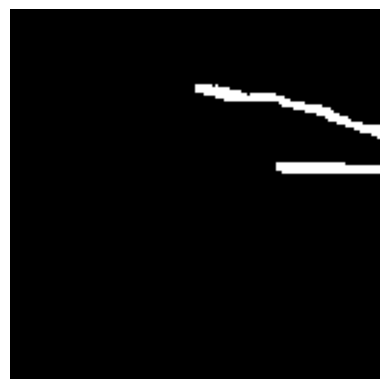

In [57]:
display_image(label[0, ...])

## Build and Compile

In [58]:
model = MV2(input_shape=[crop_wh, crop_wh, 3]).build()

In [59]:
model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 64, 64, 32)           896       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 64, 64, 32)           128       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 64, 64, 32)           0         ['batch_normalization_18

## Train

In [61]:
save_path = 'MV2net_DRIVE.h5'
save_best_only = True

In [62]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 1s 1s/step


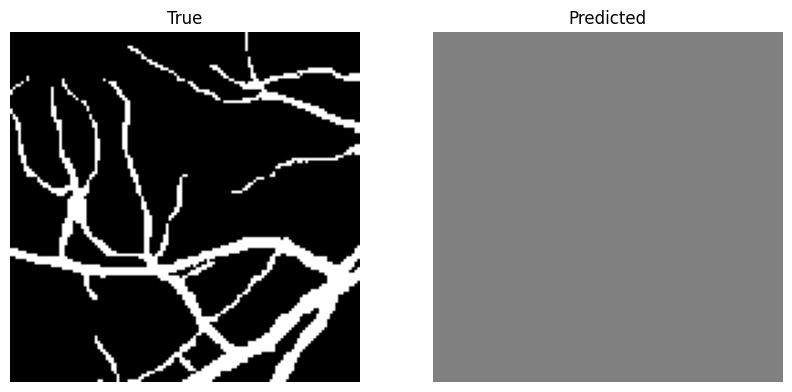


Jaccard: 0.09
Dice: 0.16


Epoch 1: val_loss improved from inf to 0.97649, saving model to MV2net_DRIVE.h5
9/9 - 49s - loss: 1.0380 - accuracy: 0.3462 - val_loss: 0.9765 - val_accuracy: 0.0812 - 49s/epoch - 5s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.97649
9/9 - 3s - loss: 0.9956 - accuracy: 0.3811 - val_loss: 0.9785 - val_accuracy: 0.0812 - 3s/epoch - 298ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.97649
9/9 - 2s - loss: 0.9749 - accuracy: 0.4306 - val_loss: 0.9778 - val_accuracy: 0.0816 - 2s/epoch - 231ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.97649 to 0.97549, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.9622 - accuracy: 0.5301 - val_loss: 0.9755 - val_accuracy: 0.3754 - 3s/epoch - 321ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.97549 to 0.97093, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.9429 - accuracy: 0.7178 - val_loss: 0.9709 - val_accuracy: 0.4757 - 4s/epoch - 418ms/step
Epoch 6/150

Epoch 6: val_loss imp

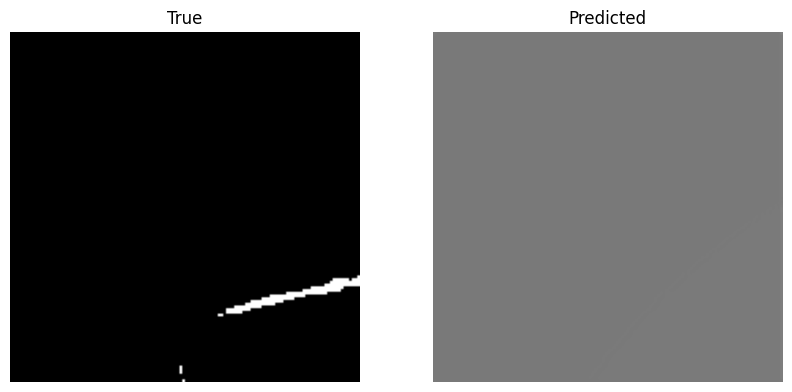


Jaccard: 0.08
Dice: 0.14


Epoch 10: val_loss improved from 0.94364 to 0.93665, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.8703 - accuracy: 0.8579 - val_loss: 0.9367 - val_accuracy: 0.9164 - 4s/epoch - 442ms/step
Epoch 11/150

Epoch 11: val_loss improved from 0.93665 to 0.92885, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.8514 - accuracy: 0.8734 - val_loss: 0.9288 - val_accuracy: 0.9178 - 4s/epoch - 396ms/step
Epoch 12/150

Epoch 12: val_loss improved from 0.92885 to 0.92095, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.8384 - accuracy: 0.8719 - val_loss: 0.9210 - val_accuracy: 0.9182 - 4s/epoch - 472ms/step
Epoch 13/150

Epoch 13: val_loss improved from 0.92095 to 0.91265, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.8307 - accuracy: 0.8747 - val_loss: 0.9127 - val_accuracy: 0.9187 - 3s/epoch - 318ms/step
Epoch 14/150

Epoch 14: val_loss improved from 0.91265 to 0.90568, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.8208 - accuracy: 0.8925 - val_loss: 

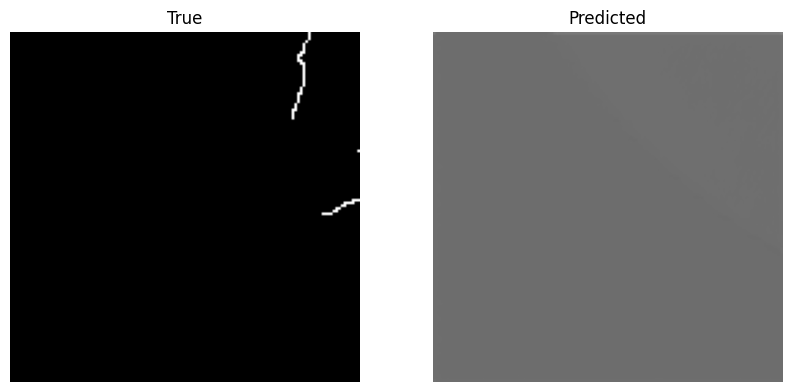


Jaccard: 0.07
Dice: 0.13


Epoch 19: val_loss improved from 0.87501 to 0.86676, saving model to MV2net_DRIVE.h5
9/9 - 6s - loss: 0.7846 - accuracy: 0.9158 - val_loss: 0.8668 - val_accuracy: 0.9187 - 6s/epoch - 662ms/step
Epoch 20/150

Epoch 20: val_loss improved from 0.86676 to 0.86012, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7798 - accuracy: 0.9157 - val_loss: 0.8601 - val_accuracy: 0.9187 - 3s/epoch - 317ms/step
Epoch 21/150

Epoch 21: val_loss improved from 0.86012 to 0.85378, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7736 - accuracy: 0.9219 - val_loss: 0.8538 - val_accuracy: 0.9187 - 3s/epoch - 362ms/step
Epoch 22/150

Epoch 22: val_loss improved from 0.85378 to 0.84795, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.7725 - accuracy: 0.9175 - val_loss: 0.8480 - val_accuracy: 0.9187 - 4s/epoch - 410ms/step
Epoch 23/150

Epoch 23: val_loss improved from 0.84795 to 0.83844, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7651 - accuracy: 0.9237 - val_loss: 

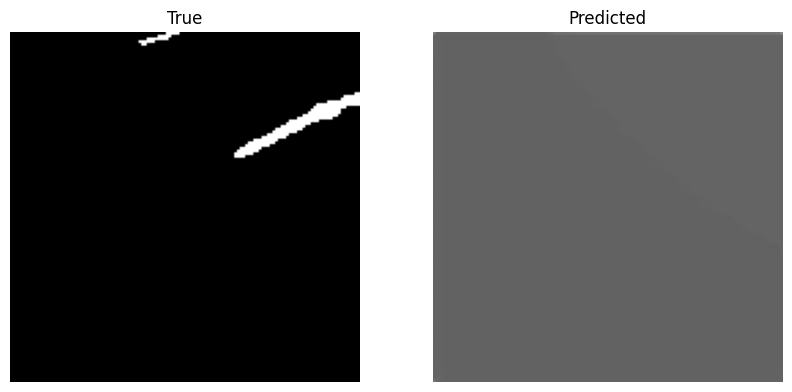


Jaccard: 0.08
Dice: 0.14


Epoch 28: val_loss improved from 0.81426 to 0.81007, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.7423 - accuracy: 0.9303 - val_loss: 0.8101 - val_accuracy: 0.9187 - 5s/epoch - 507ms/step
Epoch 29/150

Epoch 29: val_loss improved from 0.81007 to 0.80650, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7358 - accuracy: 0.9325 - val_loss: 0.8065 - val_accuracy: 0.9187 - 3s/epoch - 321ms/step
Epoch 30/150

Epoch 30: val_loss improved from 0.80650 to 0.80202, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7320 - accuracy: 0.9311 - val_loss: 0.8020 - val_accuracy: 0.9186 - 3s/epoch - 325ms/step
Epoch 31/150

Epoch 31: val_loss improved from 0.80202 to 0.79634, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.7283 - accuracy: 0.9337 - val_loss: 0.7963 - val_accuracy: 0.9186 - 4s/epoch - 441ms/step
Epoch 32/150

Epoch 32: val_loss improved from 0.79634 to 0.79013, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7249 - accuracy: 0.9345 - val_loss: 

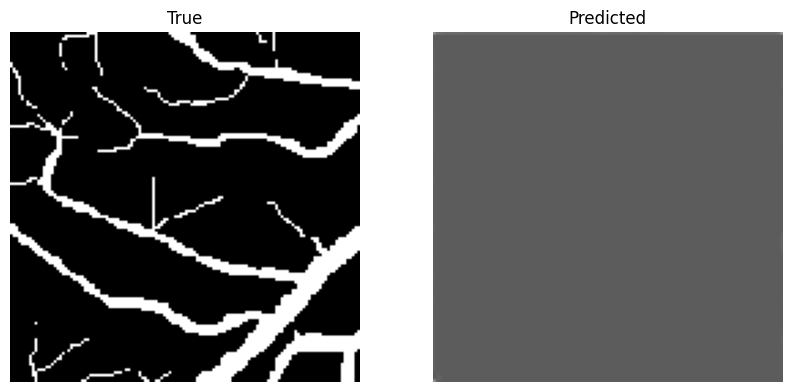


Jaccard: 0.08
Dice: 0.14


Epoch 37: val_loss improved from 0.77340 to 0.76890, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6989 - accuracy: 0.9411 - val_loss: 0.7689 - val_accuracy: 0.9181 - 4s/epoch - 440ms/step
Epoch 38/150

Epoch 38: val_loss improved from 0.76890 to 0.76469, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6952 - accuracy: 0.9421 - val_loss: 0.7647 - val_accuracy: 0.9180 - 4s/epoch - 403ms/step
Epoch 39/150

Epoch 39: val_loss improved from 0.76469 to 0.76046, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6887 - accuracy: 0.9450 - val_loss: 0.7605 - val_accuracy: 0.9181 - 3s/epoch - 324ms/step
Epoch 40/150

Epoch 40: val_loss improved from 0.76046 to 0.75890, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6840 - accuracy: 0.9460 - val_loss: 0.7589 - val_accuracy: 0.9179 - 3s/epoch - 384ms/step
Epoch 41/150

Epoch 41: val_loss improved from 0.75890 to 0.75145, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6833 - accuracy: 0.9441 - val_loss: 

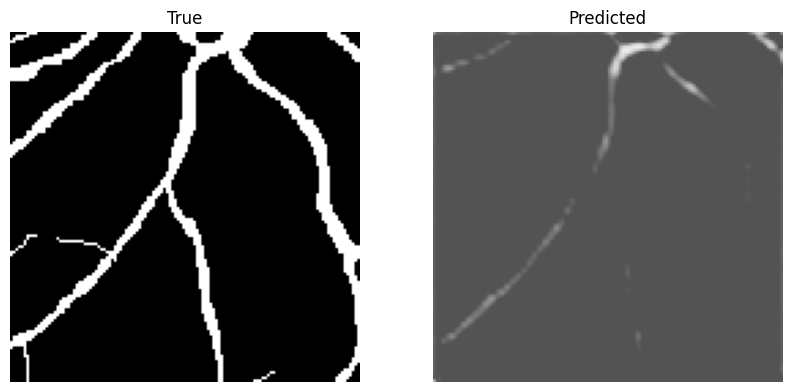


Jaccard: 0.08
Dice: 0.15


Epoch 46: val_loss improved from 0.72949 to 0.72273, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6645 - accuracy: 0.9463 - val_loss: 0.7227 - val_accuracy: 0.9195 - 4s/epoch - 441ms/step
Epoch 47/150

Epoch 47: val_loss improved from 0.72273 to 0.71932, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6623 - accuracy: 0.9471 - val_loss: 0.7193 - val_accuracy: 0.9194 - 3s/epoch - 324ms/step
Epoch 48/150

Epoch 48: val_loss improved from 0.71932 to 0.71027, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6584 - accuracy: 0.9478 - val_loss: 0.7103 - val_accuracy: 0.9197 - 4s/epoch - 413ms/step
Epoch 49/150

Epoch 49: val_loss improved from 0.71027 to 0.70290, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6532 - accuracy: 0.9484 - val_loss: 0.7029 - val_accuracy: 0.9217 - 3s/epoch - 386ms/step
Epoch 50/150

Epoch 50: val_loss improved from 0.70290 to 0.69698, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6491 - accuracy: 0.9495 - val_loss: 

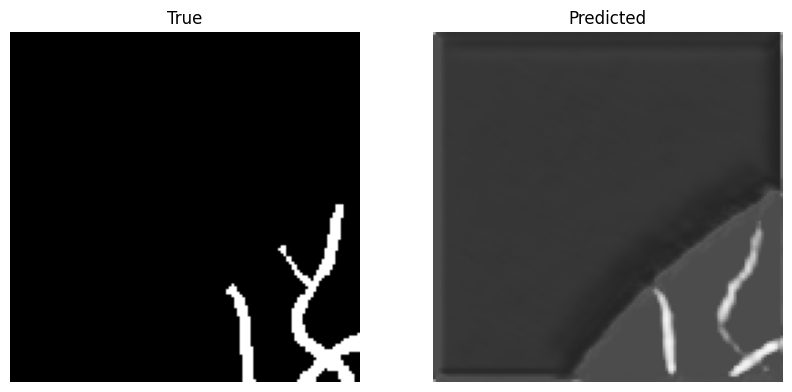


Jaccard: 0.11
Dice: 0.19


Epoch 55: val_loss improved from 0.65943 to 0.64271, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.6305 - accuracy: 0.9516 - val_loss: 0.6427 - val_accuracy: 0.9368 - 5s/epoch - 586ms/step
Epoch 56/150

Epoch 56: val_loss improved from 0.64271 to 0.64052, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6284 - accuracy: 0.9520 - val_loss: 0.6405 - val_accuracy: 0.9334 - 4s/epoch - 430ms/step
Epoch 57/150

Epoch 57: val_loss improved from 0.64052 to 0.62918, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6248 - accuracy: 0.9516 - val_loss: 0.6292 - val_accuracy: 0.9376 - 3s/epoch - 320ms/step
Epoch 58/150

Epoch 58: val_loss improved from 0.62918 to 0.61892, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6225 - accuracy: 0.9533 - val_loss: 0.6189 - val_accuracy: 0.9418 - 3s/epoch - 317ms/step
Epoch 59/150

Epoch 59: val_loss improved from 0.61892 to 0.61029, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6189 - accuracy: 0.9524 - val_loss: 

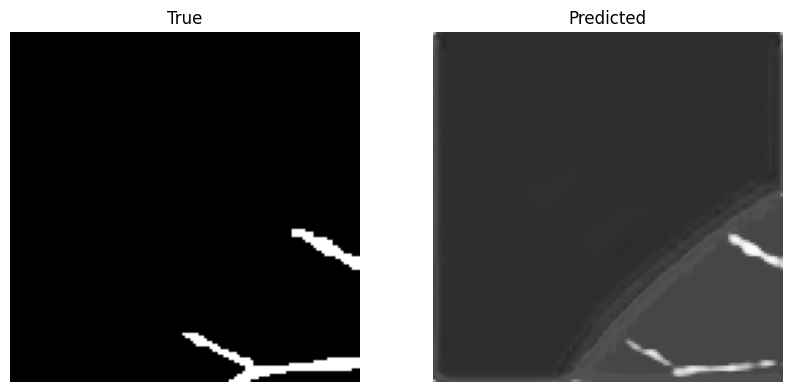


Jaccard: 0.15
Dice: 0.25


Epoch 64: val_loss improved from 0.59149 to 0.58538, saving model to MV2net_DRIVE.h5
9/9 - 6s - loss: 0.6017 - accuracy: 0.9551 - val_loss: 0.5854 - val_accuracy: 0.9530 - 6s/epoch - 632ms/step
Epoch 65/150

Epoch 65: val_loss improved from 0.58538 to 0.57982, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5976 - accuracy: 0.9548 - val_loss: 0.5798 - val_accuracy: 0.9545 - 4s/epoch - 408ms/step
Epoch 66/150

Epoch 66: val_loss improved from 0.57982 to 0.57253, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5981 - accuracy: 0.9553 - val_loss: 0.5725 - val_accuracy: 0.9558 - 3s/epoch - 387ms/step
Epoch 67/150

Epoch 67: val_loss improved from 0.57253 to 0.56545, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5923 - accuracy: 0.9561 - val_loss: 0.5655 - val_accuracy: 0.9569 - 3s/epoch - 369ms/step
Epoch 68/150

Epoch 68: val_loss improved from 0.56545 to 0.56542, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5899 - accuracy: 0.9567 - val_loss: 

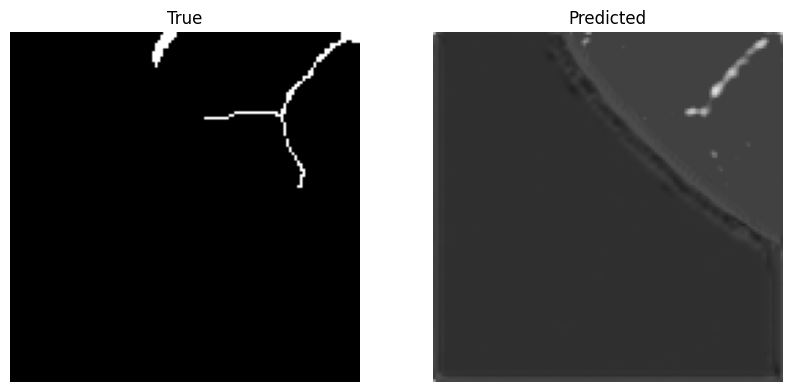


Jaccard: 0.22
Dice: 0.36


Epoch 73: val_loss improved from 0.55915 to 0.55748, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5762 - accuracy: 0.9577 - val_loss: 0.5575 - val_accuracy: 0.9574 - 4s/epoch - 437ms/step
Epoch 74/150

Epoch 74: val_loss improved from 0.55748 to 0.55497, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5758 - accuracy: 0.9566 - val_loss: 0.5550 - val_accuracy: 0.9577 - 4s/epoch - 400ms/step
Epoch 75/150

Epoch 75: val_loss improved from 0.55497 to 0.55291, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5709 - accuracy: 0.9578 - val_loss: 0.5529 - val_accuracy: 0.9595 - 4s/epoch - 477ms/step
Epoch 76/150

Epoch 76: val_loss improved from 0.55291 to 0.55245, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5685 - accuracy: 0.9569 - val_loss: 0.5525 - val_accuracy: 0.9570 - 3s/epoch - 384ms/step
Epoch 77/150

Epoch 77: val_loss improved from 0.55245 to 0.54606, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5659 - accuracy: 0.9579 - val_loss: 

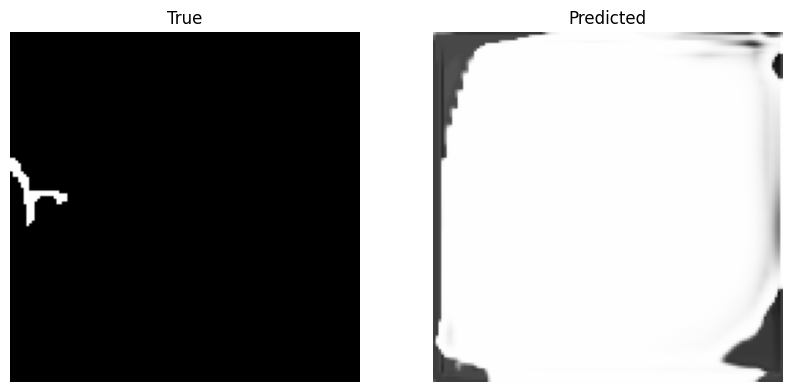


Jaccard: 0.07
Dice: 0.13


Epoch 82: val_loss did not improve from 0.54606
9/9 - 3s - loss: 0.5764 - accuracy: 0.9504 - val_loss: 4.6714 - val_accuracy: 0.3033 - 3s/epoch - 338ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.54606
9/9 - 3s - loss: 0.5719 - accuracy: 0.9504 - val_loss: 2.1310 - val_accuracy: 0.6883 - 3s/epoch - 365ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.54606
9/9 - 2s - loss: 0.5664 - accuracy: 0.9527 - val_loss: 1.4520 - val_accuracy: 0.8062 - 2s/epoch - 228ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.54606
9/9 - 2s - loss: 0.5627 - accuracy: 0.9532 - val_loss: 1.0845 - val_accuracy: 0.8599 - 2s/epoch - 225ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.54606
9/9 - 3s - loss: 0.5598 - accuracy: 0.9527 - val_loss: 0.8890 - val_accuracy: 0.8932 - 3s/epoch - 301ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.54606
9/9 - 2s - loss: 0.5564 - accuracy: 0.9536 - val_loss: 0.7429 - val_a

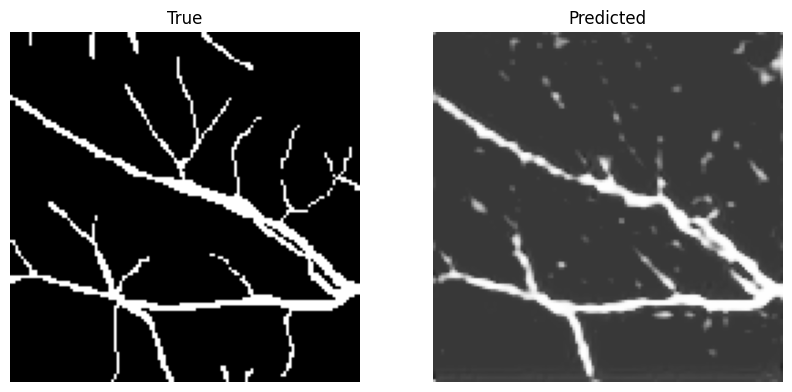


Jaccard: 0.22
Dice: 0.36


Epoch 91: val_loss improved from 0.54606 to 0.54430, saving model to MV2net_DRIVE.h5
9/9 - 7s - loss: 0.5461 - accuracy: 0.9549 - val_loss: 0.5443 - val_accuracy: 0.9539 - 7s/epoch - 726ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.54430
9/9 - 2s - loss: 0.5421 - accuracy: 0.9558 - val_loss: 0.5549 - val_accuracy: 0.9492 - 2s/epoch - 230ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.54430
9/9 - 3s - loss: 0.5401 - accuracy: 0.9555 - val_loss: 0.5653 - val_accuracy: 0.9486 - 3s/epoch - 289ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.54430
9/9 - 4s - loss: 0.5372 - accuracy: 0.9562 - val_loss: 0.5477 - val_accuracy: 0.9523 - 4s/epoch - 449ms/step
Epoch 95/150

Epoch 95: val_loss improved from 0.54430 to 0.53214, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5335 - accuracy: 0.9570 - val_loss: 0.5321 - val_accuracy: 0.9540 - 4s/epoch - 492ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.5

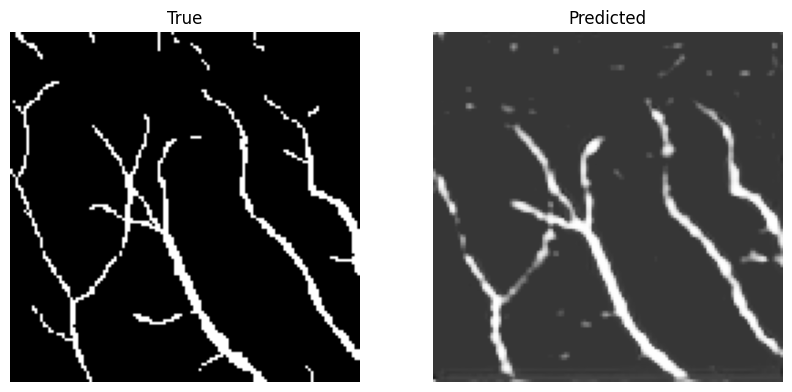


Jaccard: 0.25
Dice: 0.40


Epoch 100: val_loss did not improve from 0.53214
9/9 - 3s - loss: 0.5209 - accuracy: 0.9580 - val_loss: 0.5327 - val_accuracy: 0.9537 - 3s/epoch - 341ms/step
Epoch 101/150

Epoch 101: val_loss improved from 0.53214 to 0.52391, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5178 - accuracy: 0.9587 - val_loss: 0.5239 - val_accuracy: 0.9564 - 4s/epoch - 440ms/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.52391
9/9 - 3s - loss: 0.5157 - accuracy: 0.9592 - val_loss: 0.5303 - val_accuracy: 0.9528 - 3s/epoch - 320ms/step
Epoch 103/150

Epoch 103: val_loss improved from 0.52391 to 0.52006, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5139 - accuracy: 0.9591 - val_loss: 0.5201 - val_accuracy: 0.9545 - 3s/epoch - 372ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.52006
9/9 - 3s - loss: 0.5112 - accuracy: 0.9592 - val_loss: 0.5285 - val_accuracy: 0.9535 - 3s/epoch - 300ms/step
Epoch 105/150

Epoch 105: val_loss improved from

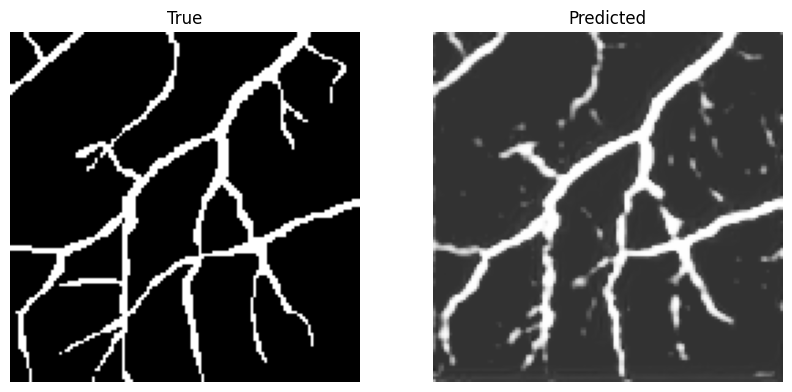


Jaccard: 0.26
Dice: 0.41


Epoch 109: val_loss improved from 0.51518 to 0.50985, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.4984 - accuracy: 0.9612 - val_loss: 0.5098 - val_accuracy: 0.9551 - 5s/epoch - 517ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.50985
9/9 - 5s - loss: 0.4966 - accuracy: 0.9612 - val_loss: 0.5141 - val_accuracy: 0.9537 - 5s/epoch - 519ms/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.50985
9/9 - 2s - loss: 0.4954 - accuracy: 0.9611 - val_loss: 0.5158 - val_accuracy: 0.9522 - 2s/epoch - 236ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.50985
9/9 - 2s - loss: 0.4944 - accuracy: 0.9605 - val_loss: 0.5159 - val_accuracy: 0.9525 - 2s/epoch - 227ms/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.50985
9/9 - 2s - loss: 0.4913 - accuracy: 0.9612 - val_loss: 0.5150 - val_accuracy: 0.9551 - 2s/epoch - 224ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.50985
9/9 - 2s - loss: 0.48

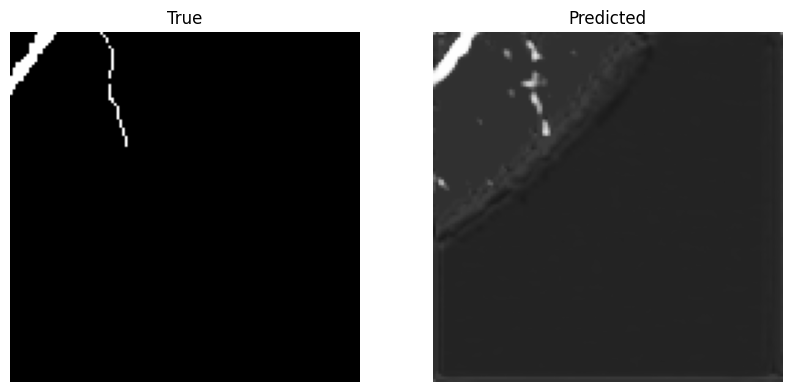


Jaccard: 0.27
Dice: 0.42


Epoch 118: val_loss improved from 0.50779 to 0.50692, saving model to MV2net_DRIVE.h5
9/9 - 6s - loss: 0.4809 - accuracy: 0.9621 - val_loss: 0.5069 - val_accuracy: 0.9534 - 6s/epoch - 657ms/step
Epoch 119/150

Epoch 119: val_loss improved from 0.50692 to 0.50133, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4790 - accuracy: 0.9623 - val_loss: 0.5013 - val_accuracy: 0.9530 - 3s/epoch - 320ms/step
Epoch 120/150

Epoch 120: val_loss improved from 0.50133 to 0.49688, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4761 - accuracy: 0.9631 - val_loss: 0.4969 - val_accuracy: 0.9549 - 3s/epoch - 318ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.49688
9/9 - 3s - loss: 0.4749 - accuracy: 0.9625 - val_loss: 0.5045 - val_accuracy: 0.9538 - 3s/epoch - 310ms/step
Epoch 122/150

Epoch 122: val_loss improved from 0.49688 to 0.49251, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.4729 - accuracy: 0.9628 - val_loss: 0.4925 - val_accuracy: 0.956

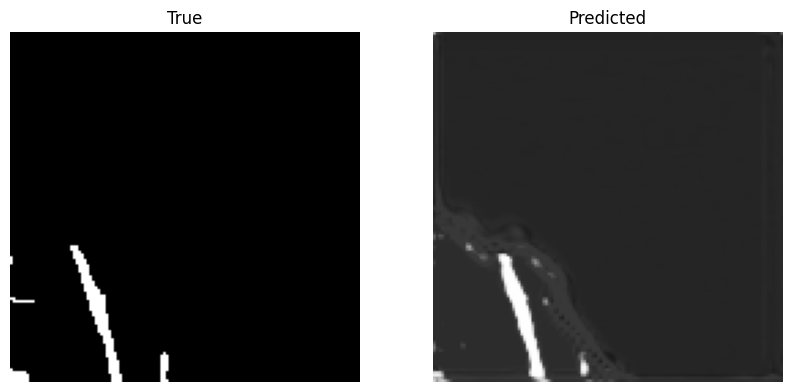


Jaccard: 0.27
Dice: 0.43


Epoch 127: val_loss did not improve from 0.48194
9/9 - 4s - loss: 0.4635 - accuracy: 0.9640 - val_loss: 0.4865 - val_accuracy: 0.9547 - 4s/epoch - 445ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.48194
9/9 - 2s - loss: 0.4632 - accuracy: 0.9625 - val_loss: 0.4875 - val_accuracy: 0.9537 - 2s/epoch - 259ms/step
Epoch 129/150

Epoch 129: val_loss improved from 0.48194 to 0.47714, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.4609 - accuracy: 0.9639 - val_loss: 0.4771 - val_accuracy: 0.9559 - 5s/epoch - 523ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.47714
9/9 - 3s - loss: 0.4580 - accuracy: 0.9636 - val_loss: 0.4821 - val_accuracy: 0.9541 - 3s/epoch - 295ms/step
Epoch 131/150

Epoch 131: val_loss improved from 0.47714 to 0.47351, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4570 - accuracy: 0.9632 - val_loss: 0.4735 - val_accuracy: 0.9561 - 3s/epoch - 322ms/step
Epoch 132/150

Epoch 132: val_loss improved from

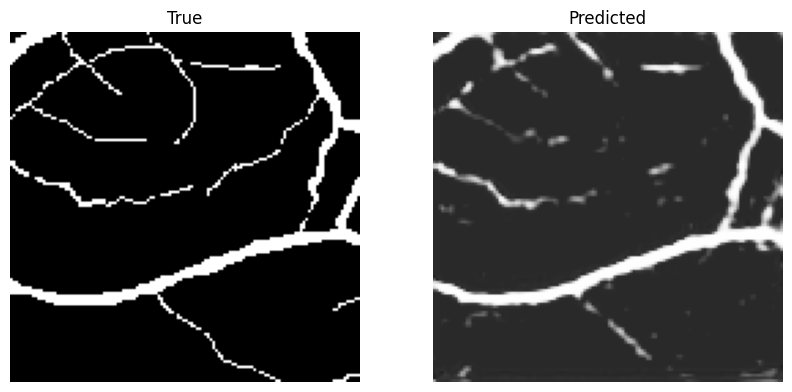


Jaccard: 0.28
Dice: 0.44


Epoch 136: val_loss did not improve from 0.47192
9/9 - 4s - loss: 0.4485 - accuracy: 0.9646 - val_loss: 0.4751 - val_accuracy: 0.9551 - 4s/epoch - 498ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.47192
9/9 - 3s - loss: 0.4463 - accuracy: 0.9635 - val_loss: 0.4863 - val_accuracy: 0.9521 - 3s/epoch - 305ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.47192
9/9 - 3s - loss: 0.4503 - accuracy: 0.9629 - val_loss: 0.4792 - val_accuracy: 0.9528 - 3s/epoch - 290ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.47192
9/9 - 3s - loss: 0.4433 - accuracy: 0.9643 - val_loss: 0.4728 - val_accuracy: 0.9550 - 3s/epoch - 297ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.47192
9/9 - 3s - loss: 0.4399 - accuracy: 0.9655 - val_loss: 0.4728 - val_accuracy: 0.9552 - 3s/epoch - 305ms/step
Epoch 141/150

Epoch 141: val_loss improved from 0.47192 to 0.46995, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.43

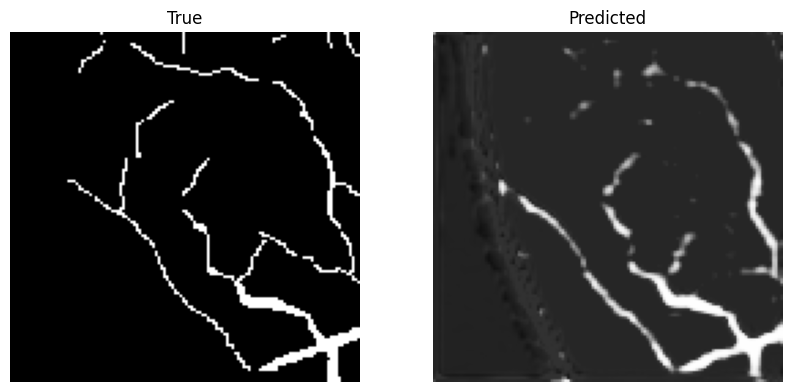


Jaccard: 0.31
Dice: 0.47


Epoch 145: val_loss did not improve from 0.46252
9/9 - 3s - loss: 0.4306 - accuracy: 0.9660 - val_loss: 0.4728 - val_accuracy: 0.9524 - 3s/epoch - 375ms/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.46252
9/9 - 3s - loss: 0.4293 - accuracy: 0.9662 - val_loss: 0.4651 - val_accuracy: 0.9535 - 3s/epoch - 338ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.46252
9/9 - 3s - loss: 0.4288 - accuracy: 0.9658 - val_loss: 0.4637 - val_accuracy: 0.9539 - 3s/epoch - 299ms/step
Epoch 148/150

Epoch 148: val_loss improved from 0.46252 to 0.45645, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4272 - accuracy: 0.9657 - val_loss: 0.4565 - val_accuracy: 0.9542 - 3s/epoch - 367ms/step
Epoch 149/150

Epoch 149: val_loss improved from 0.45645 to 0.45097, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4284 - accuracy: 0.9648 - val_loss: 0.4510 - val_accuracy: 0.9560 - 3s/epoch - 355ms/step
Epoch 150/150

Epoch 150: val_loss did not impro

In [63]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

## Evaluate and Plot Results

In [64]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='color',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 3 channel image.


In [65]:
test = test_data.get_dataset()

In [66]:
_ = model.evaluate(test)

20/20 [==============================] - 1s 38ms/step - loss: 0.4140 - accuracy: 0.9640


In [67]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

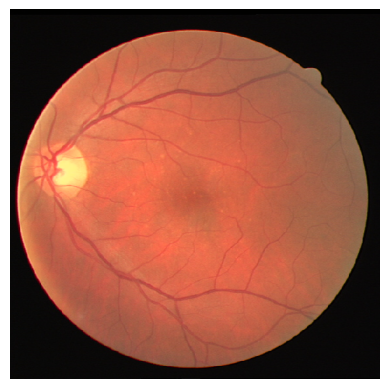

In [68]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 1s 908ms/step


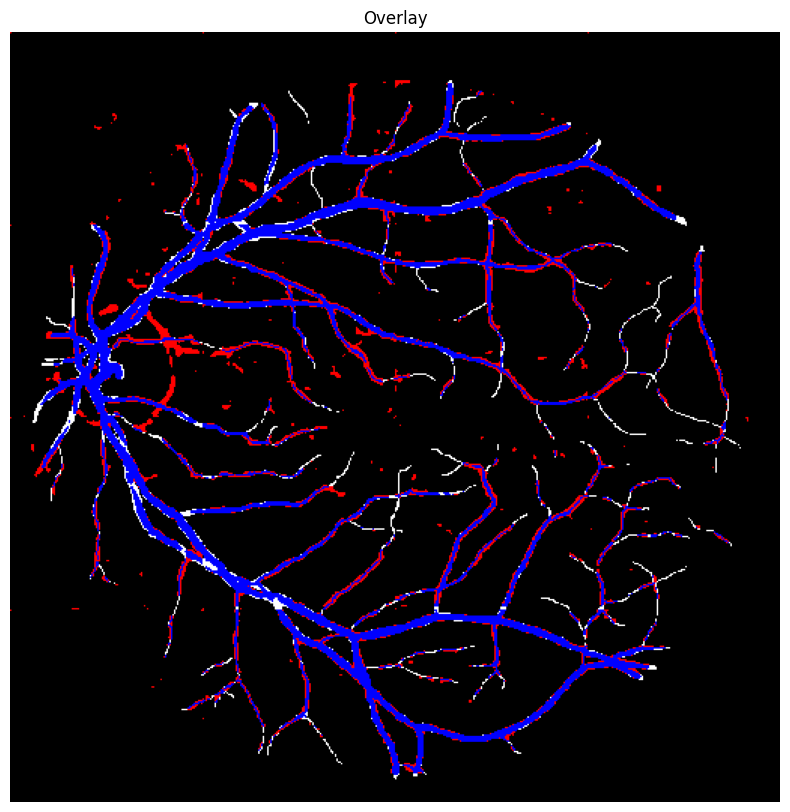

In [69]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))